In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns
import xarray as xr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "birthdays"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
raw_df = pd.read_csv(
    "https://raw.githubusercontent.com/avehtari/casestudies/master/Birthdays/data/births_usa_1969.csv",
)

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   year          7305 non-null   int64
 1   month         7305 non-null   int64
 2   day           7305 non-null   int64
 3   births        7305 non-null   int64
 4   day_of_year   7305 non-null   int64
 5   day_of_week   7305 non-null   int64
 6   id            7305 non-null   int64
 7   day_of_year2  7305 non-null   int64
dtypes: int64(8)
memory usage: 456.7 KB


In [4]:
raw_df.head()

year  month  day  births  day_of_year  day_of_week  id  day_of_year2
0  1969      1    1    8486            1            3   1             1
1  1969      1    2    9002            2            4   2             2
2  1969      1    3    9542            3            5   3             3
3  1969      1    4    8960            4            6   4             4
4  1969      1    5    8390            5            7   5             5

In [5]:
data_df = raw_df.copy().assign(
    date=lambda x: pd.to_datetime(x[["year", "month", "day"]]),
    births_relative100=lambda x: x["births"] / x["births"].mean() * 100,
    obs=lambda x: x.index,
)

data_df.head()

year  month  day  births  day_of_year  day_of_week  id  day_of_year2  \
0  1969      1    1    8486            1            3   1             1   
1  1969      1    2    9002            2            4   2             2   
2  1969      1    3    9542            3            5   3             3   
3  1969      1    4    8960            4            6   4             4   
4  1969      1    5    8390            5            7   5             5   

        date  births_relative100  obs  
0 1969-01-01           87.947483    0  
1 1969-01-02           93.295220    1  
2 1969-01-03           98.891690    2  
3 1969-01-04           92.859939    3  
4 1969-01-05           86.952555    4

Text(0.5, 1.0, 'Relative Births in the USA in 1969')

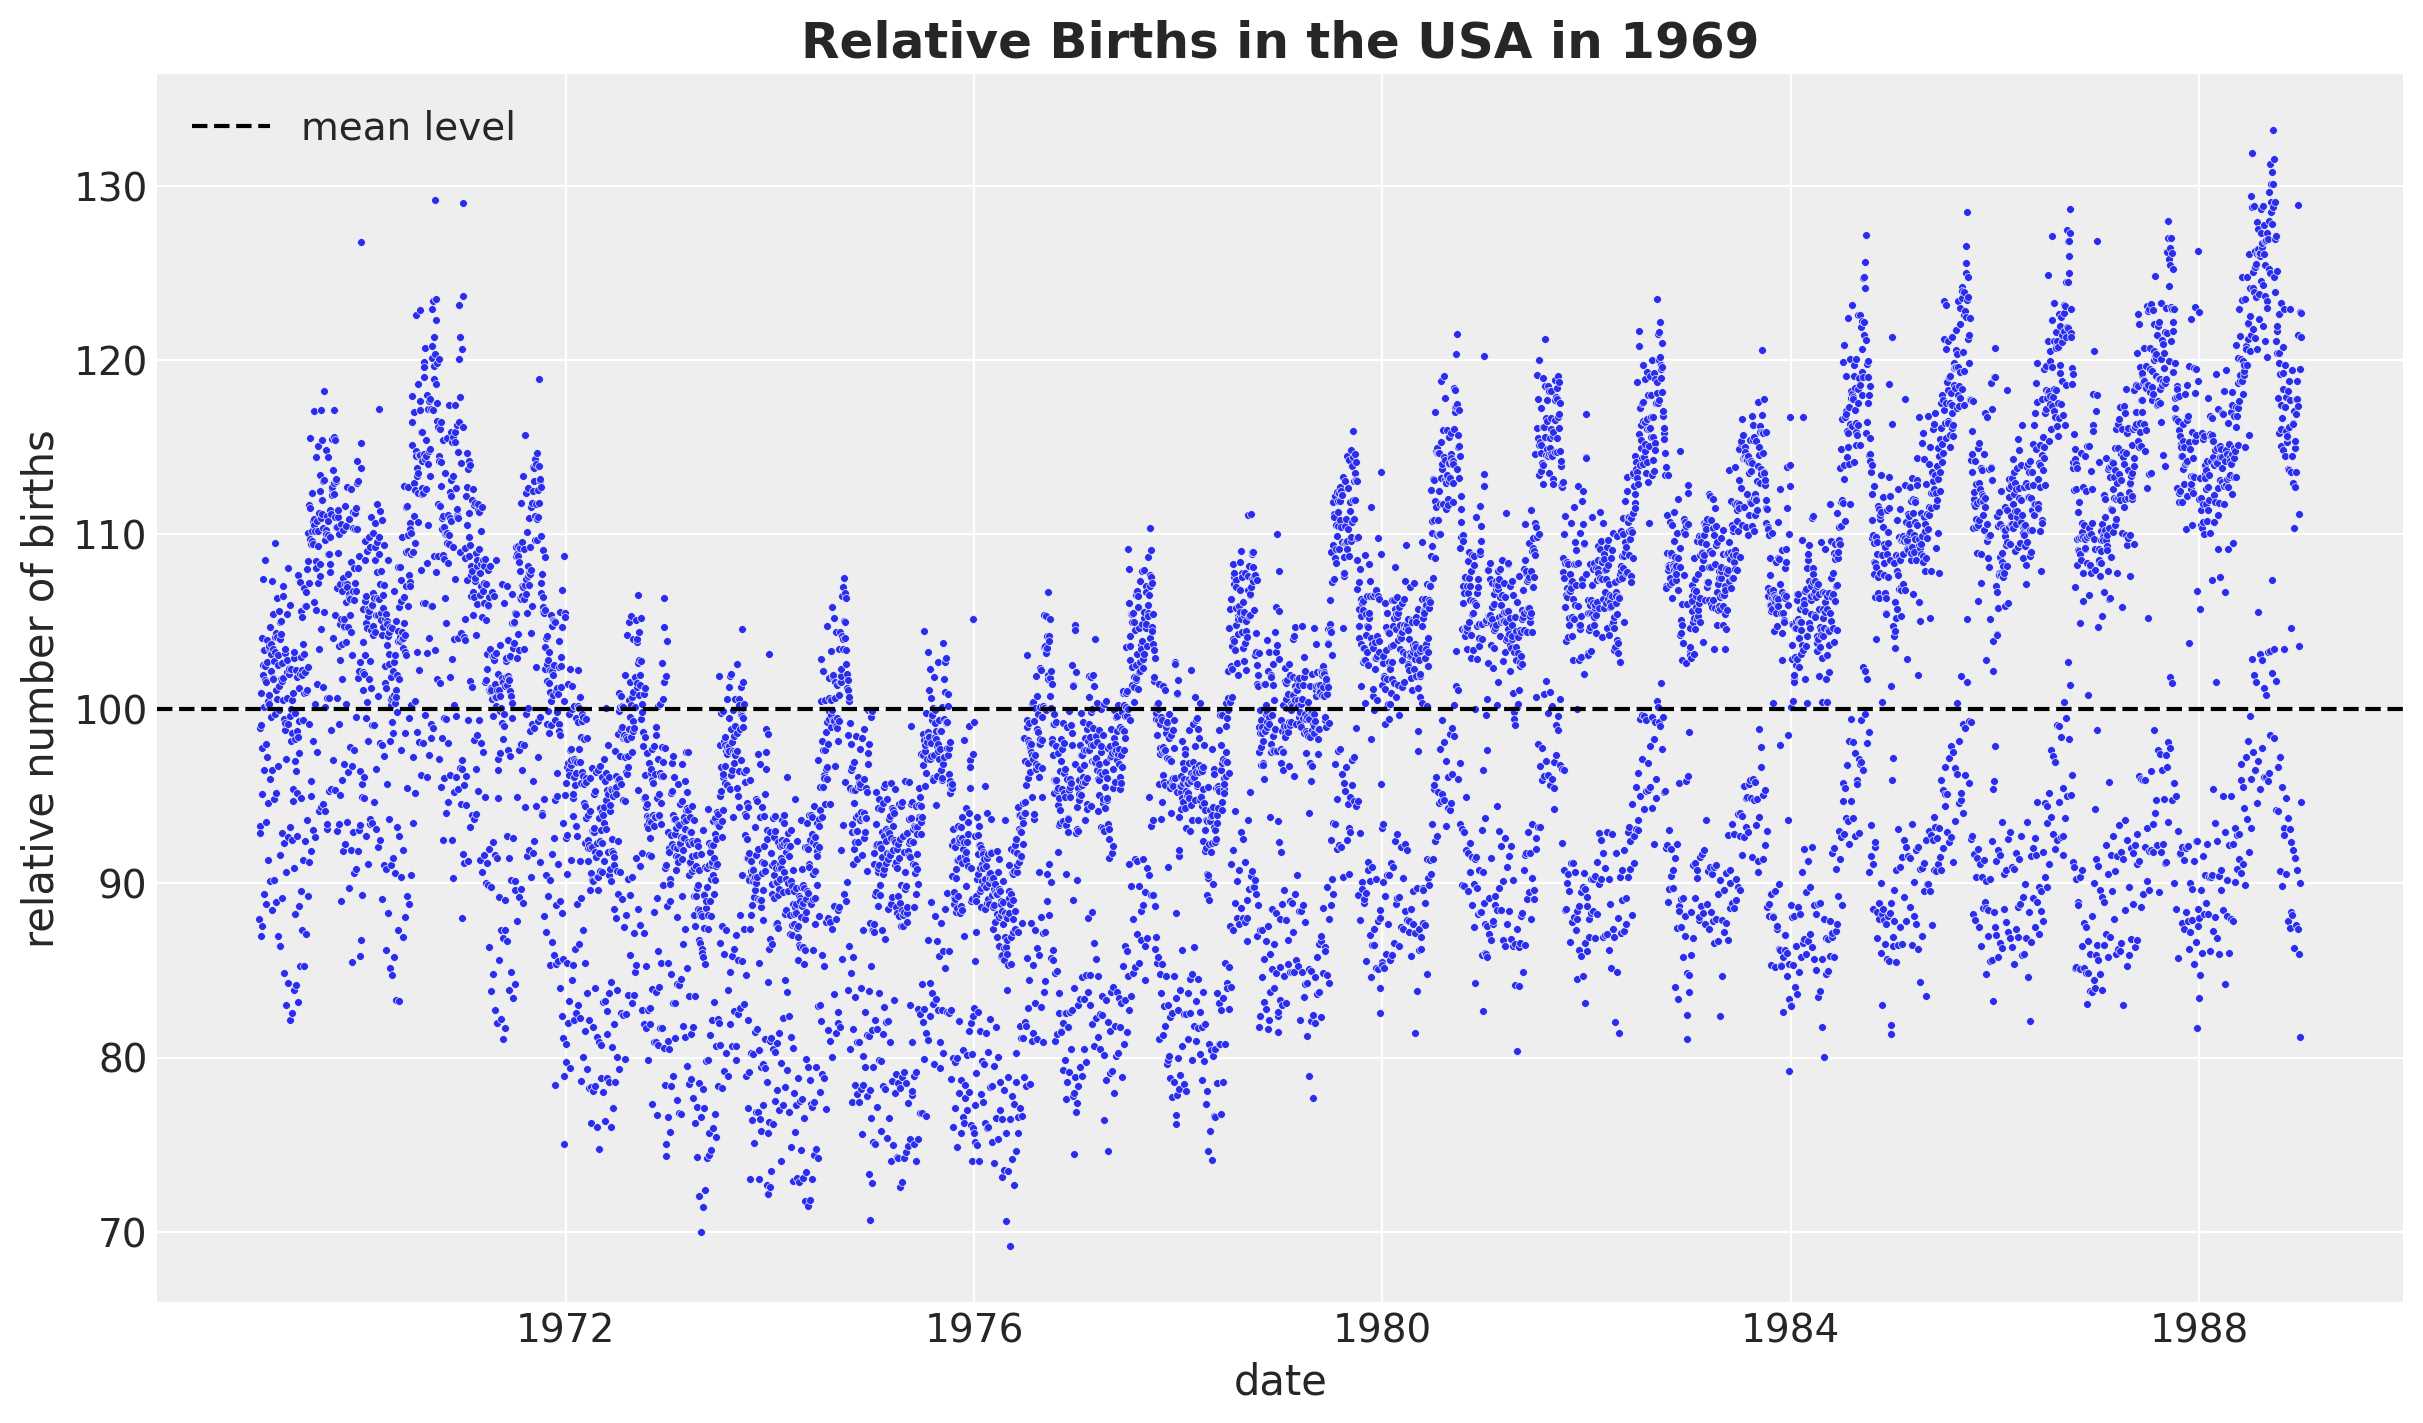

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="date", y="births_relative100", c="C0", s=8, ax=ax)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(label="Relative Births in the USA in 1969", fontsize=18, fontweight="bold")

[Text(0.5, 0, 'day of year'),
 Text(0, 0.5, 'relative number of births per day of year')]

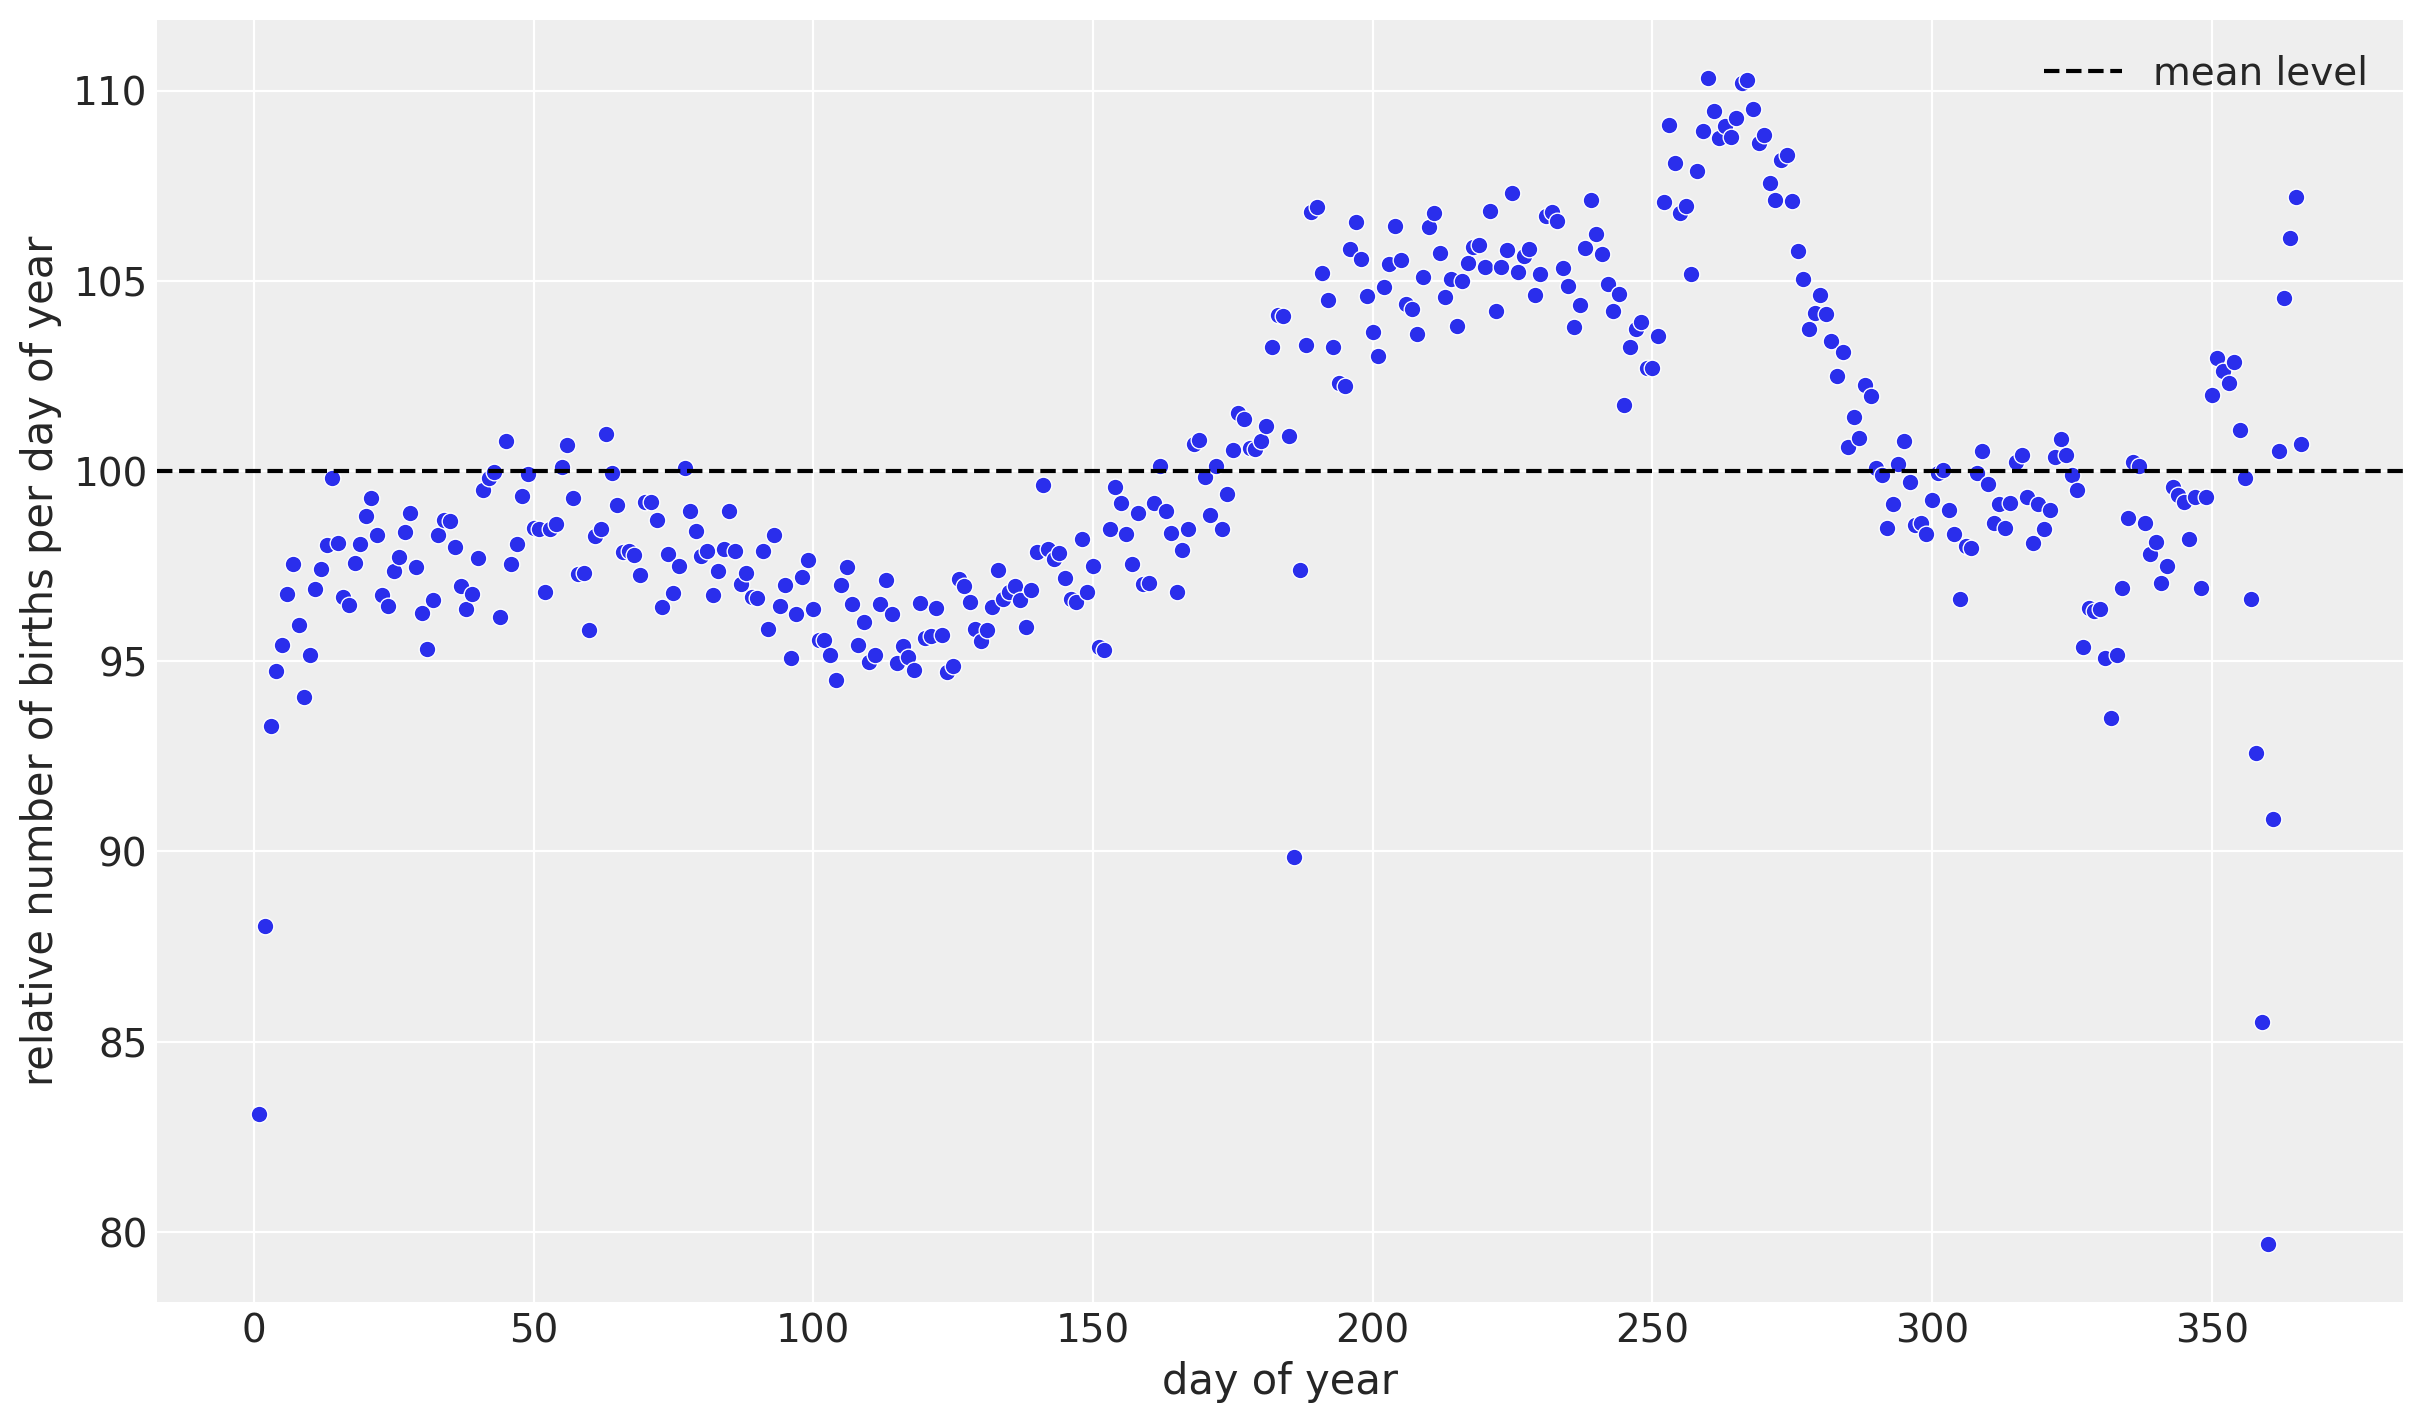

In [7]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_year2"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe((sns.scatterplot, "data"), x="day_of_year2", y="meanbirths", c="C0", ax=ax)
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of year", ylabel="relative number of births per day of year")

[Text(0.5, 0, 'day of week'),
 Text(0, 0.5, 'relative number of births per day of week')]

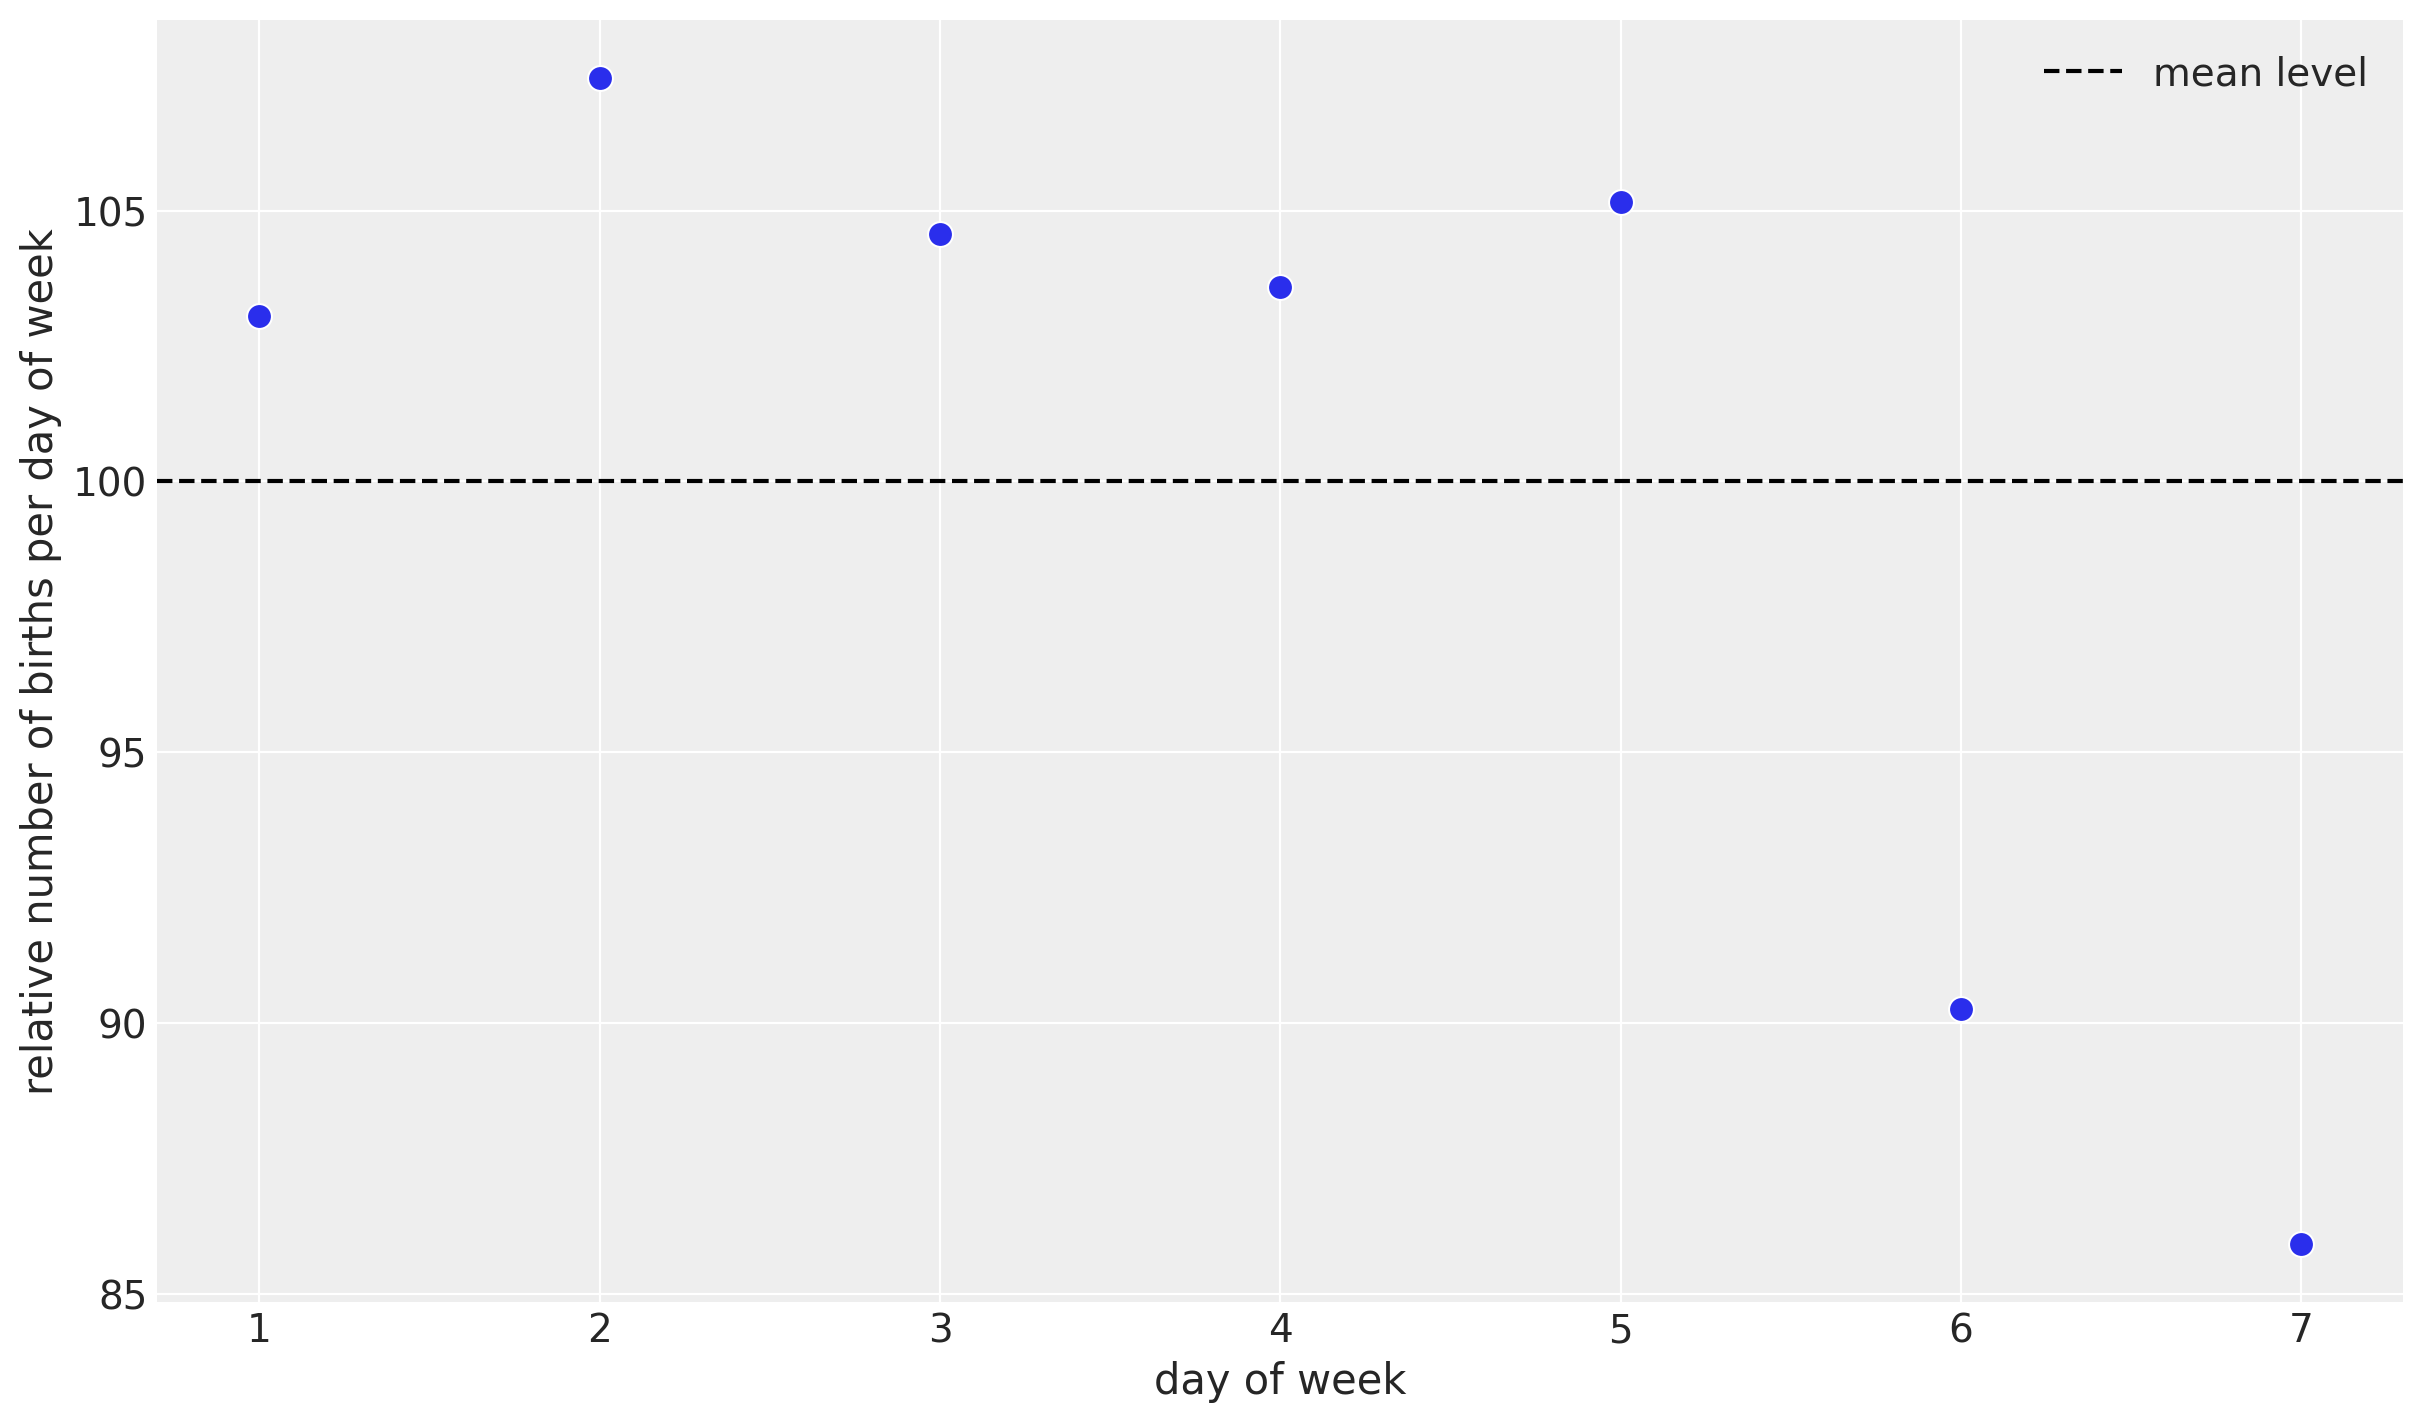

In [8]:
fig, ax = plt.subplots()
(
    data_df.groupby(["day_of_week"], as_index=False)
    .agg(meanbirths=("births_relative100", "mean"))
    .pipe(
        (sns.scatterplot, "data"), x="day_of_week", y="meanbirths", c="C0", s=80, ax=ax
    )
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
ax.legend()
ax.set(xlabel="day of week", ylabel="relative number of births per day of week")

In [9]:
n = data_df.shape[0]
obs = data_df["obs"].to_numpy()
date = data_df["date"].to_numpy()
year = data_df["year"].to_numpy()
day_of_week_idx, day_of_week = data_df["day_of_week"].factorize(sort=True)
day_of_year2_idx, day_of_year2 = data_df["day_of_year2"].factorize(sort=True)
births_relative100 = data_df["births_relative100"].to_numpy()

In [10]:
obs_pipeline = Pipeline(steps=[("scaler", StandardScaler())])

obs_pipeline.fit(obs.reshape(-1, 1))
normalized_obs = obs_pipeline.transform(obs.reshape(-1, 1))

obs_std = obs_pipeline["scaler"].scale_.item()

births_relative100_pipeline = Pipeline(
    steps=[
        ("log", FunctionTransformer(func=np.log, inverse_func=np.exp)),
        ("scaler", StandardScaler()),
    ]
)

births_relative100_pipeline.fit(births_relative100.reshape(-1, 1))
normalized_log_births_relative100 = births_relative100_pipeline.transform(
    births_relative100.reshape(-1, 1)
)
normalized_log_births_relative100_std = births_relative100_pipeline[
    "scaler"
].scale_.item()

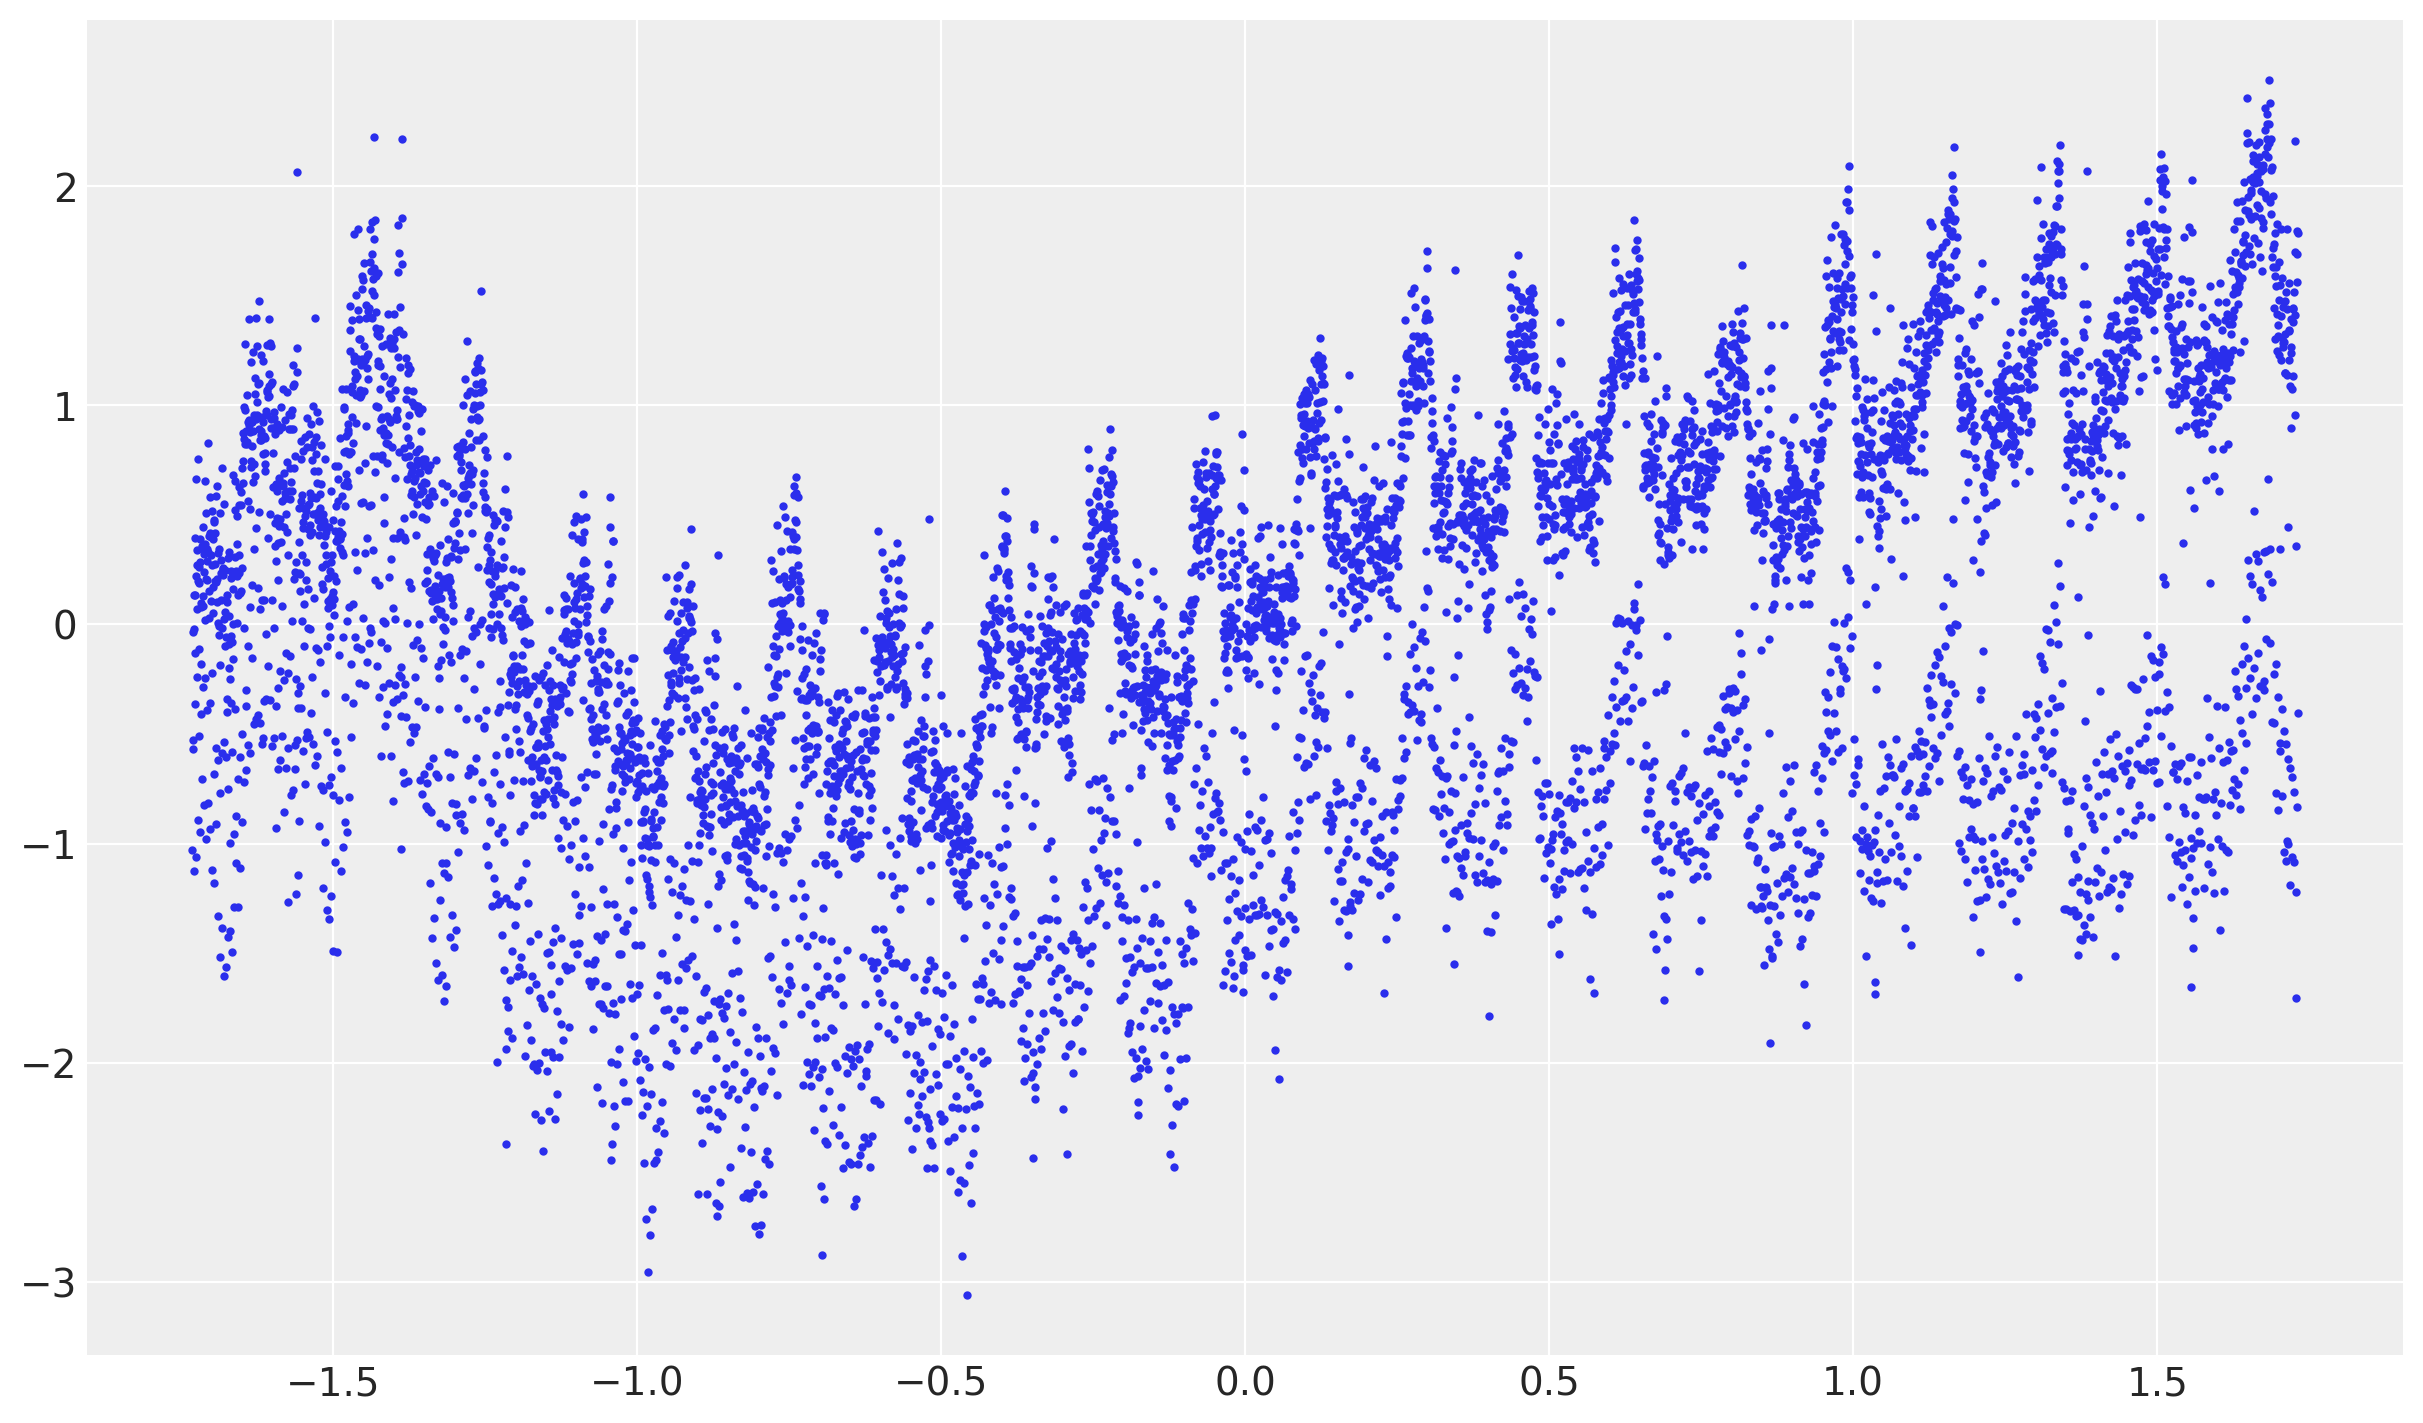

In [11]:
plt.plot(normalized_obs, normalized_log_births_relative100, "o", c="C0", markersize=2)

In [12]:
obs_std = obs.std()
normalized_obs = (obs - obs.mean()) / obs.std()


log_births_relative100 = np.log(births_relative100)
normalized_log_births_relative100 = (
    log_births_relative100 - log_births_relative100.mean()
) / log_births_relative100.std()

<Axes: >

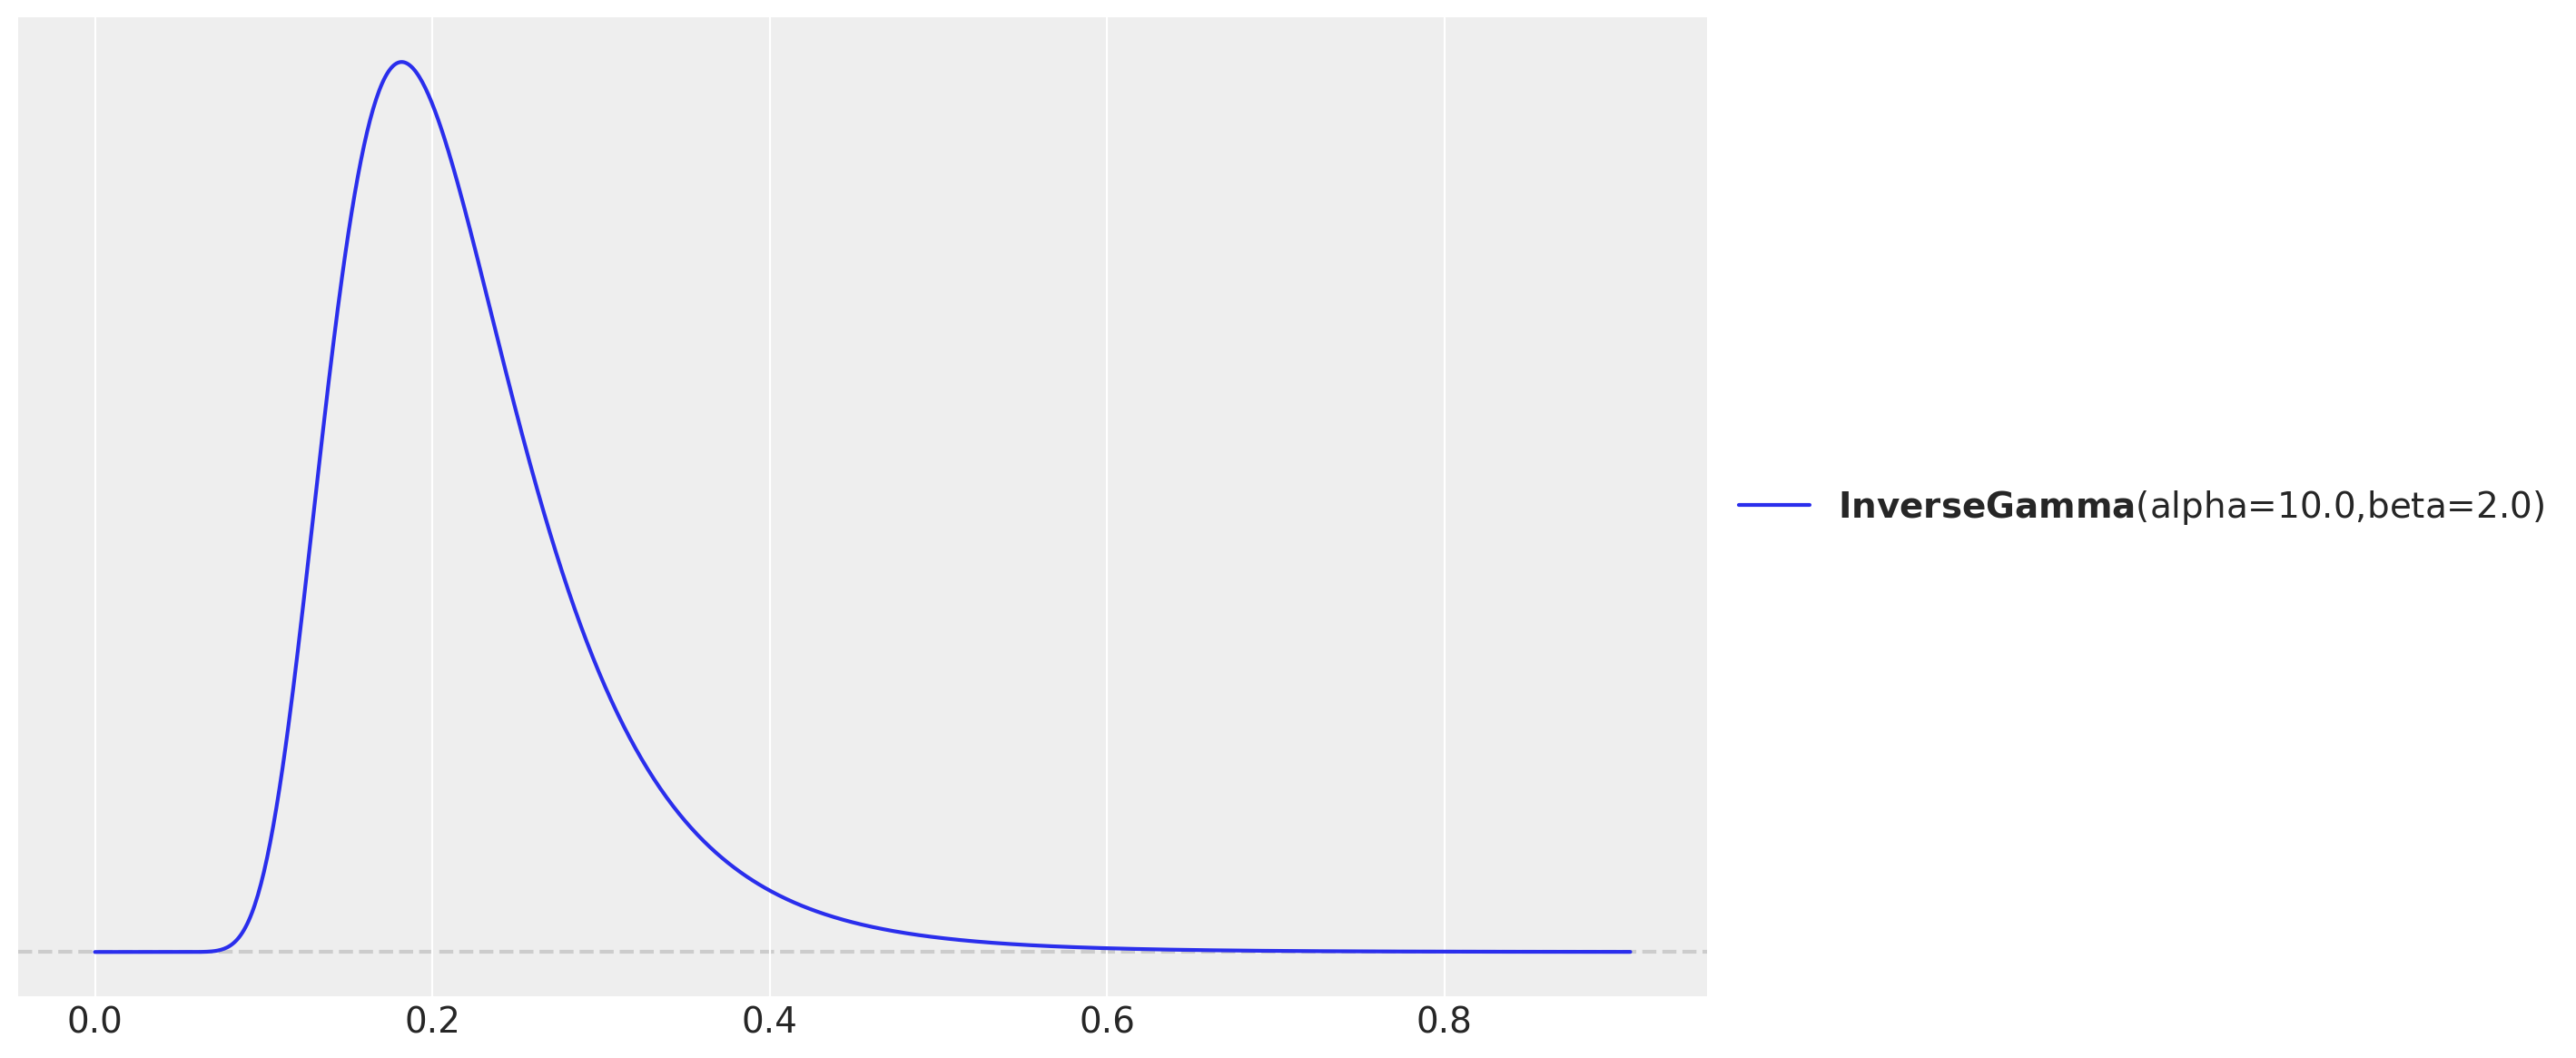

In [13]:
pz.InverseGamma(alpha=10, beta=2).plot_pdf()

<Axes: >

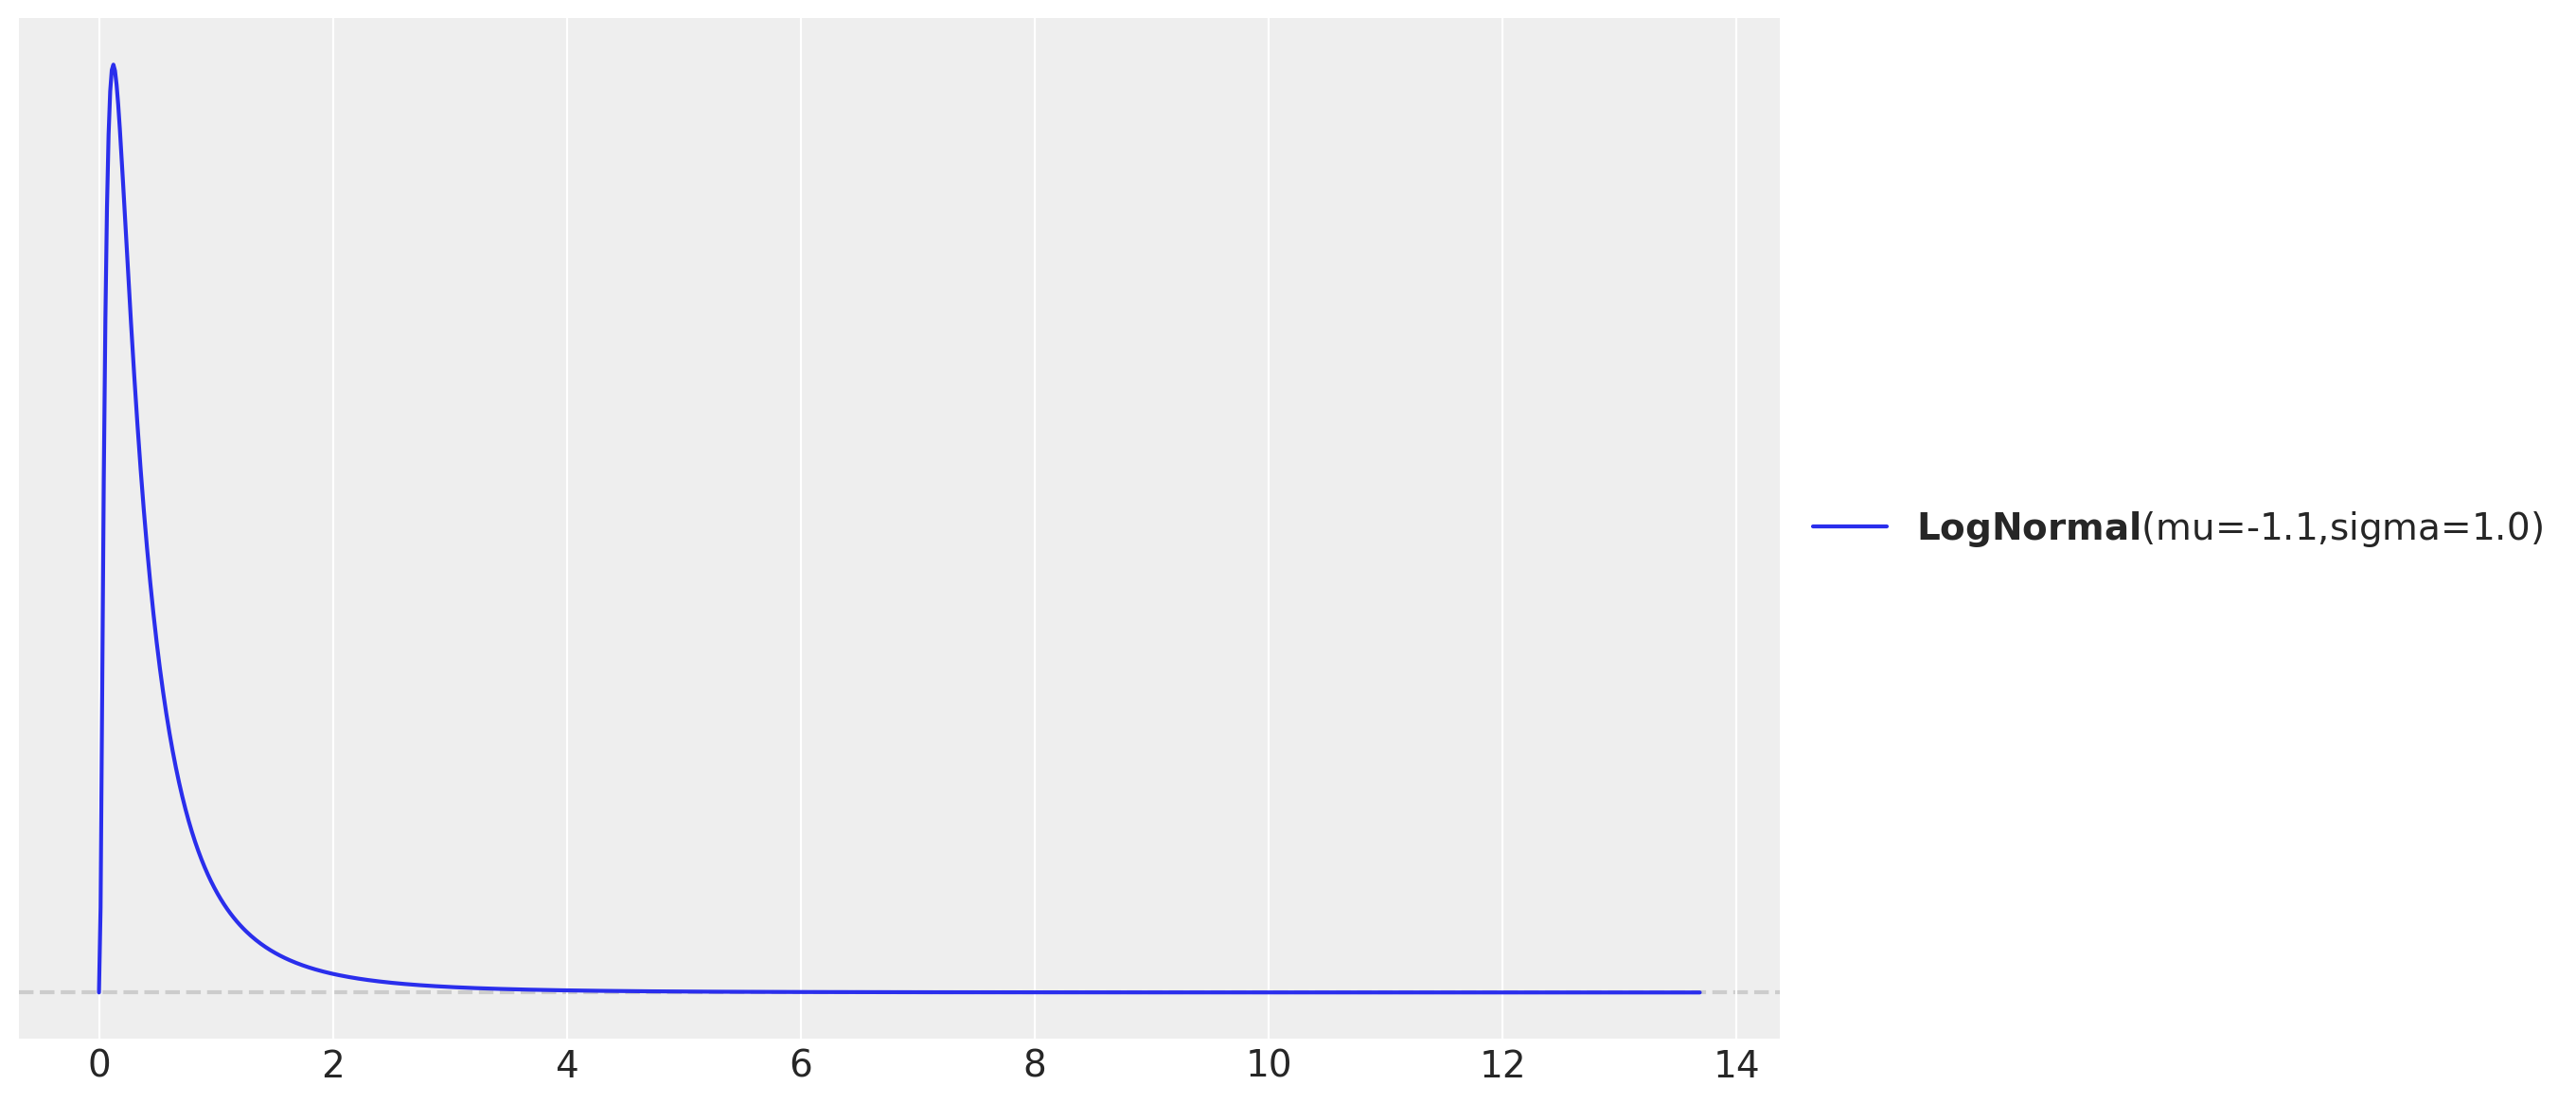

In [14]:
pz.LogNormal(mu=np.log(700 / obs_std), sigma=1).plot_pdf()

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


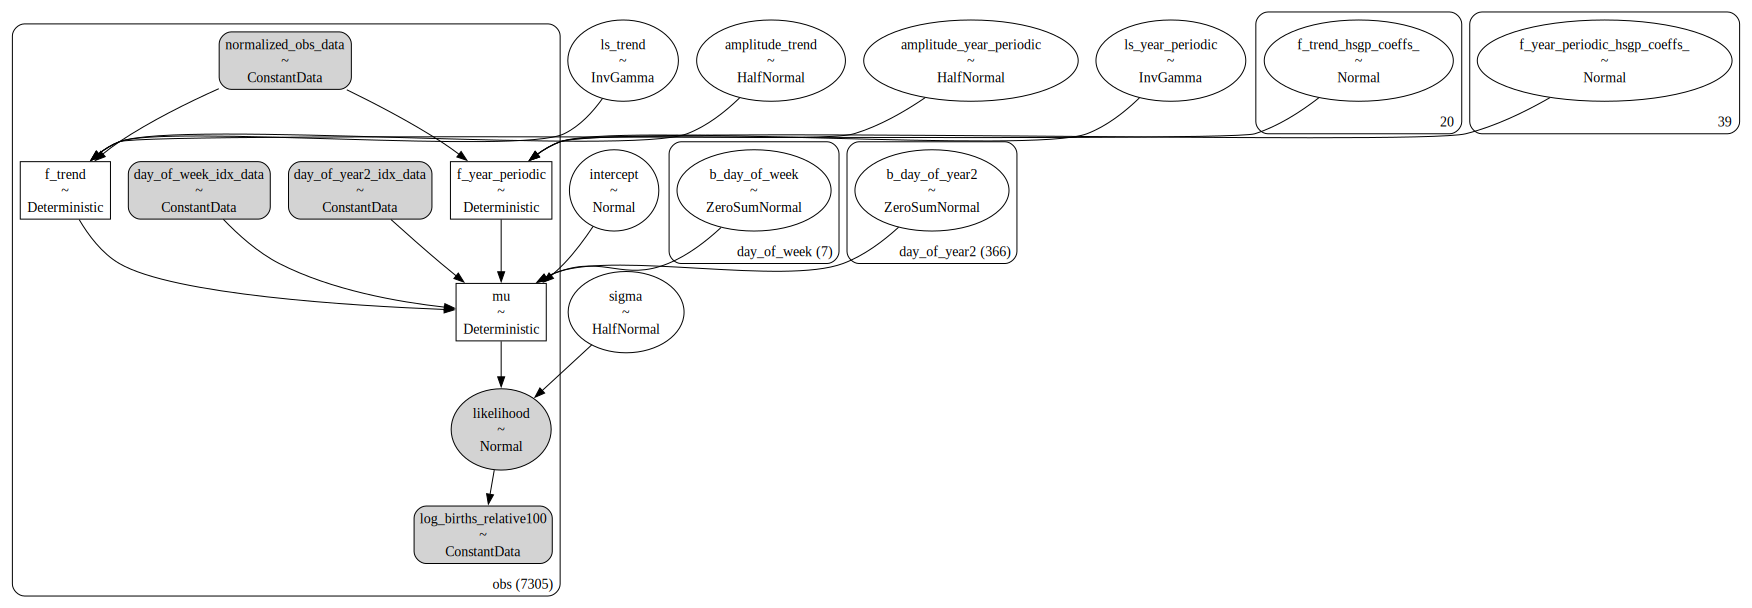

In [15]:
coords = {"obs": obs, "day_of_week": day_of_week, "day_of_year2": day_of_year2}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    normalized_obs_data = pm.Data(
        name="normalized_obs_data", value=normalized_obs, mutable=False, dims="obs"
    )

    day_of_week_idx_data = pm.Data(
        name="day_of_week_idx_data", value=day_of_week_idx, dims="obs"
    )

    day_of_year2_idx_data = pm.Data(
        name="day_of_year2_idx_data", value=day_of_year2_idx, dims="obs"
    )

    normalized_log_births_relative100_data = pm.Data(
        name="log_births_relative100",
        value=normalized_log_births_relative100,
        mutable=False,
        dims="obs",
    )

    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1.0)
    ls_trend = pm.InverseGamma(name="ls_trend", alpha=10, beta=2)
    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)

    amplitude_year_periodic = pm.HalfNormal(name="amplitude_year_periodic", sigma=1)
    ls_year_periodic = pm.InverseGamma(name="ls_year_periodic", alpha=10, beta=2)
    gp_year_periodic = pm.gp.HSGPPeriodic(
        m=20,
        scale=amplitude_year_periodic,
        cov_func=pm.gp.cov.Periodic(
            input_dim=1, period=365.25 / obs_std, ls=ls_year_periodic
        ),
    )

    f_trend = gp_trend.prior(name="f_trend", X=normalized_obs_data[:, None], dims="obs")

    f_year_periodic = gp_year_periodic.prior(
        name="f_year_periodic", X=normalized_obs_data[:, None], dims="obs"
    )

    b_day_of_week = pm.ZeroSumNormal(name="b_day_of_week", sigma=1, dims="day_of_week")

    b_day_of_year2 = pm.ZeroSumNormal(
        name="b_day_of_year2", sigma=0.5, dims="day_of_year2"
    )

    sigma = pm.HalfNormal(name="sigma", sigma=0.5)

    # --- Parametrization ---
    mu = pm.Deterministic(
        name="mu",
        var=intercept
        + f_trend
        + f_year_periodic
        + b_day_of_week[day_of_week_idx_data]
        + b_day_of_year2[day_of_year2_idx_data],
        dims="obs",
    )

    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=normalized_log_births_relative100_data,
        dims="obs",
    )

pm.model_to_graphviz(model=model)

In [16]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [amplitude_trend, amplitude_year_periodic, b_day_of_week, b_day_of_year2, f_trend_hsgp_coeffs_, f_year_periodic_hsgp_coeffs_, intercept, likelihood, ls_trend, ls_year_periodic, sigma]


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Prior Predictive')

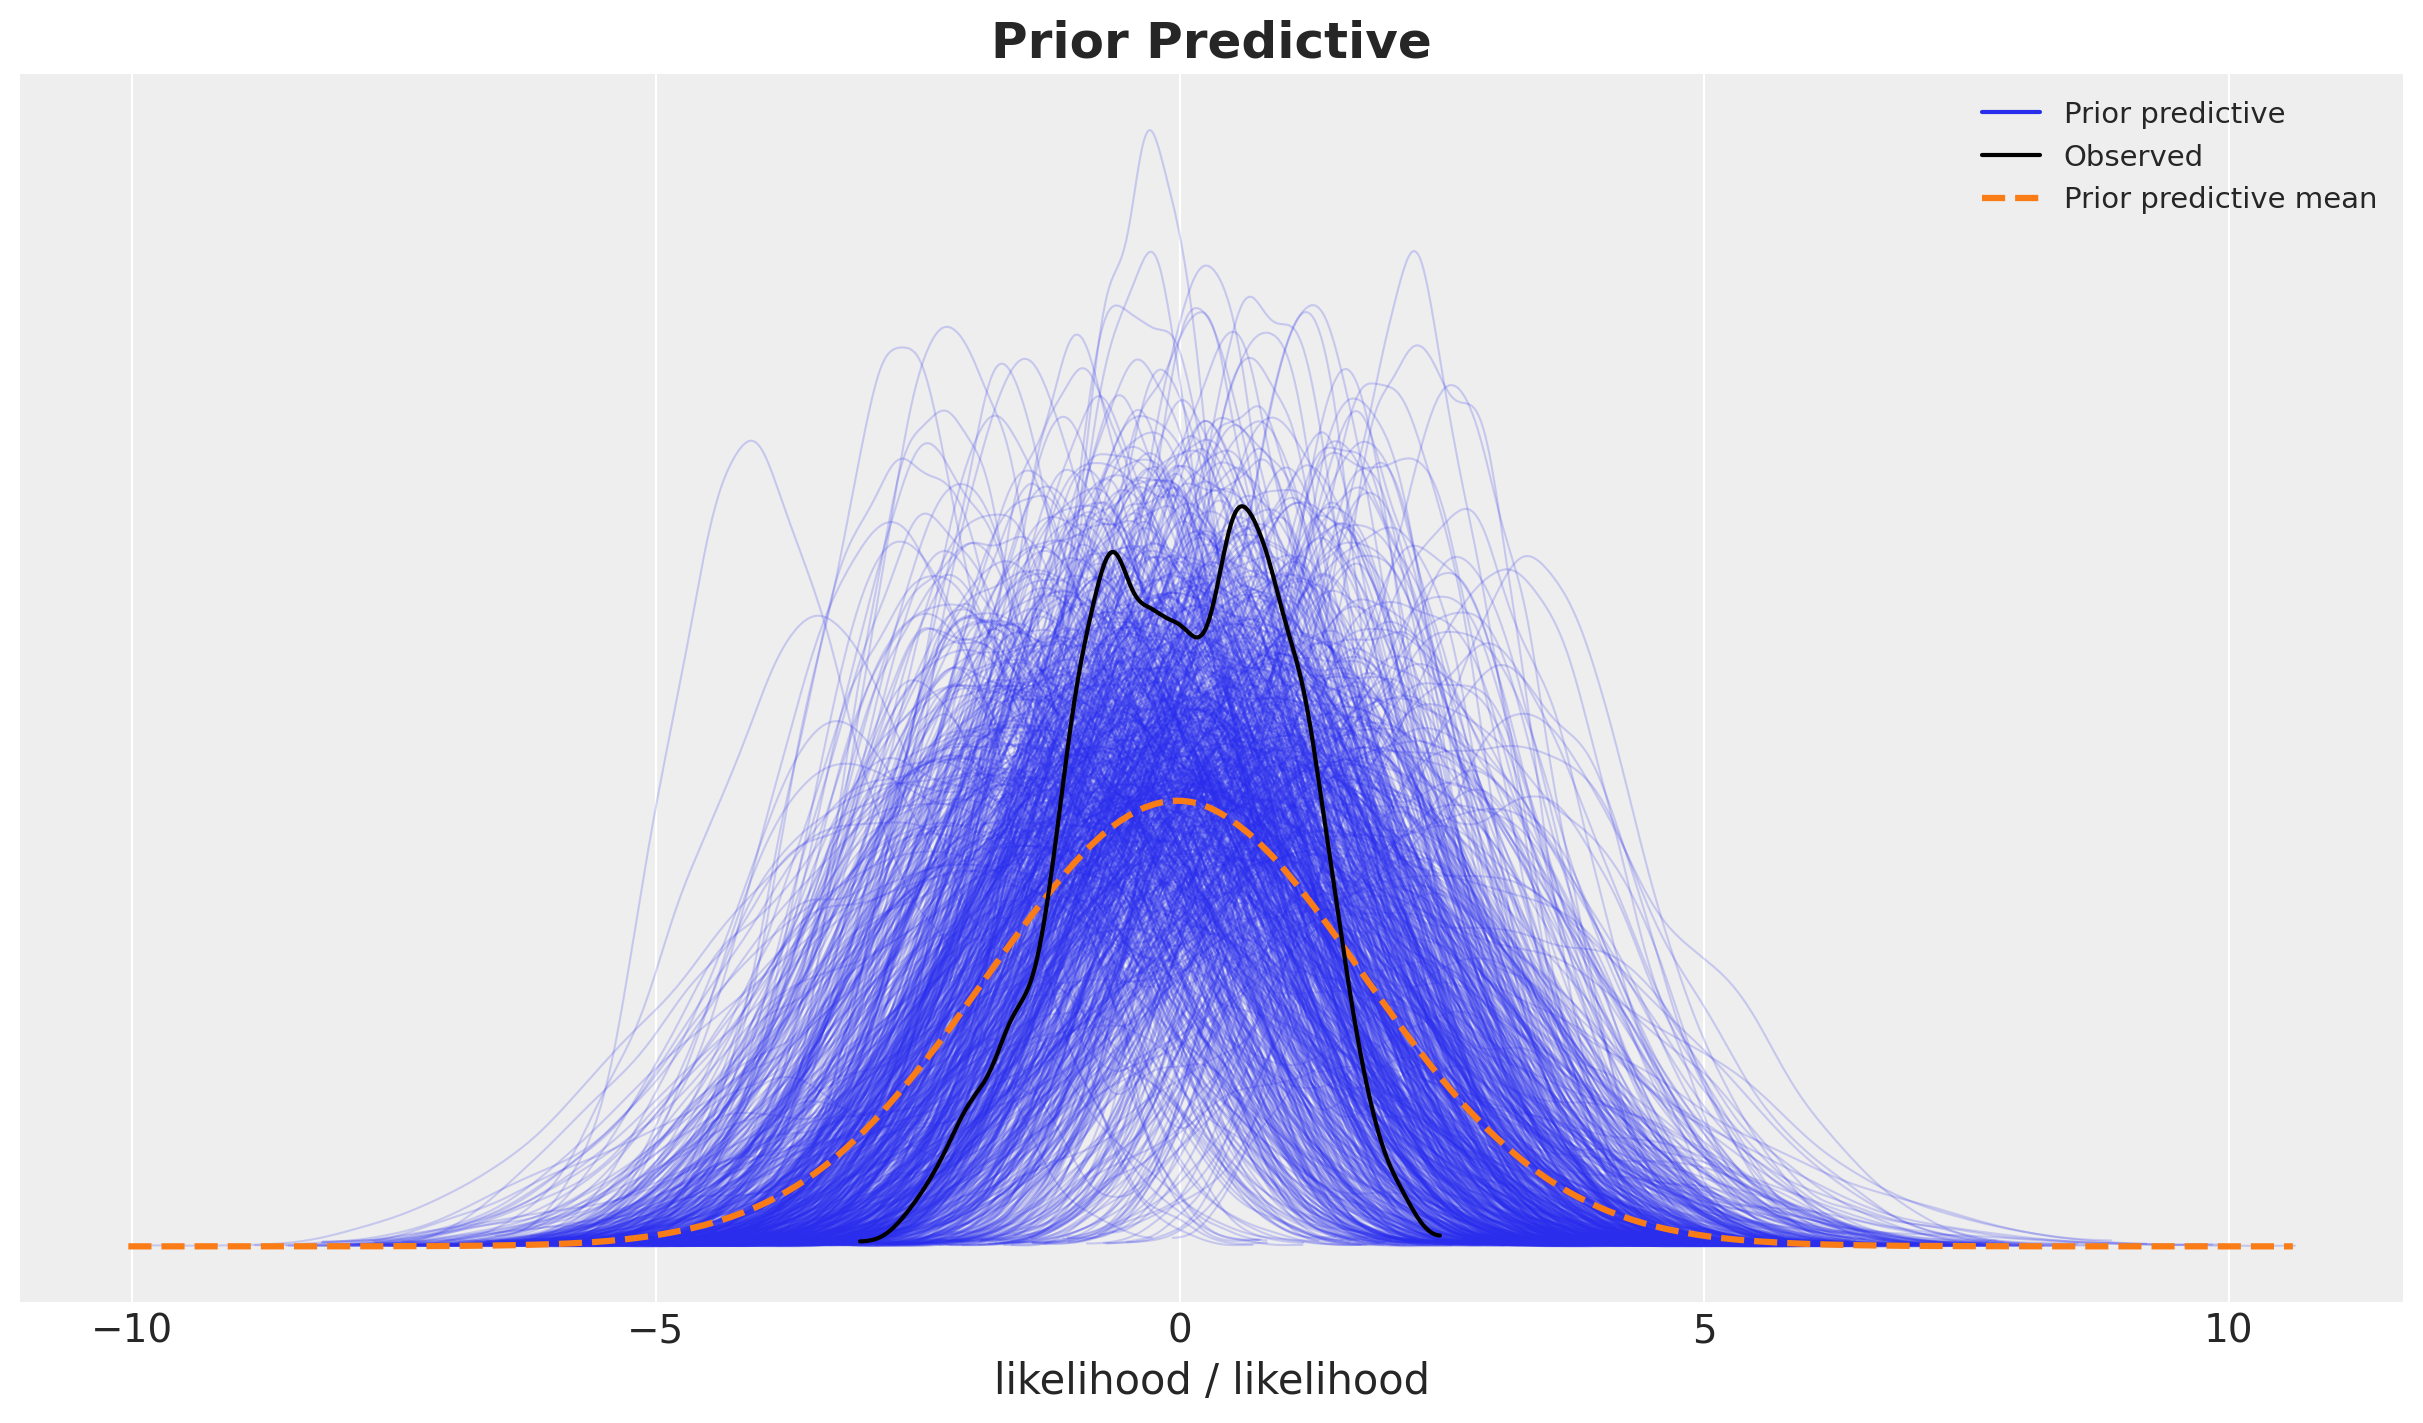

In [17]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive", fontsize=18, fontweight="bold")

In [18]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=1_000,
        chains=2,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Compiling...
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:701: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Compilation time = 0:00:22.262324
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:08:17.407094
Transforming variables...
Transformation time = 0:00:07.354514
Sampling: [likelihood]


In [19]:
idata["sample_stats"]["diverging"].sum().item()

0

In [20]:
var_names = [
    "intercept",
    "amplitude_trend",
    "ls_trend",
    "amplitude_year_periodic",
    "ls_year_periodic",
    "b_day_of_week",
    "sigma",
]

az.summary(data=idata, var_names=var_names, round_to=3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
intercept                0.013  0.247  -0.455    0.474      0.008    0.006   
amplitude_trend          0.424  0.207   0.144    0.792      0.008    0.005   
ls_trend                 0.205  0.031   0.148    0.267      0.001    0.001   
amplitude_year_periodic  0.687  0.183   0.398    1.022      0.011    0.007   
ls_year_periodic         0.376  0.112   0.213    0.599      0.013    0.009   
b_day_of_week[1]         0.274  0.008   0.259    0.289      0.000    0.000   
b_day_of_week[2]         0.628  0.008   0.614    0.643      0.000    0.000   
b_day_of_week[3]         0.402  0.008   0.387    0.416      0.000    0.000   
b_day_of_week[4]         0.321  0.009   0.305    0.337      0.000    0.000   
b_day_of_week[5]         0.454  0.008   0.439    0.470      0.000    0.000   
b_day_of_week[6]        -0.829  0.008  -0.845   -0.813      0.000    0.000   
b_day_of_week[7]        -1.250  0.008  -1.264   -1.234      0.000    0.000   
sigma                    0.285  0.002   0.281    0.290      0.000    0.000   

                         ess_bulk  ess_tail  r_hat  
intercept                 962.339  1035.646  1.000  
amplitude_trend           697.150  1041.615  1.008  
ls_trend                  650.923  1031.634  1.006  
amplitude_year_periodic   266.957   468.426  1.009  
ls_year_periodic           77.219   172.951  1.040  
b_day_of_week[1]         2836.070  1186.937  0.999  
b_day_of_week[2]         3427.637  1684.988  1.000  
b_day_of_week[3]         2929.681  1354.421  0.999  
b_day_of_week[4]         3772.960  1516.822  1.001  
b_day_of_week[5]         2865.069  1464.125  1.001  
b_day_of_week[6]         3827.094  1548.726  0.999  
b_day_of_week[7]         3012.890  1413.588  1.000  
sigma                    2979.068  1582.713  1.000

Text(0.5, 0.98, 'Rrace')

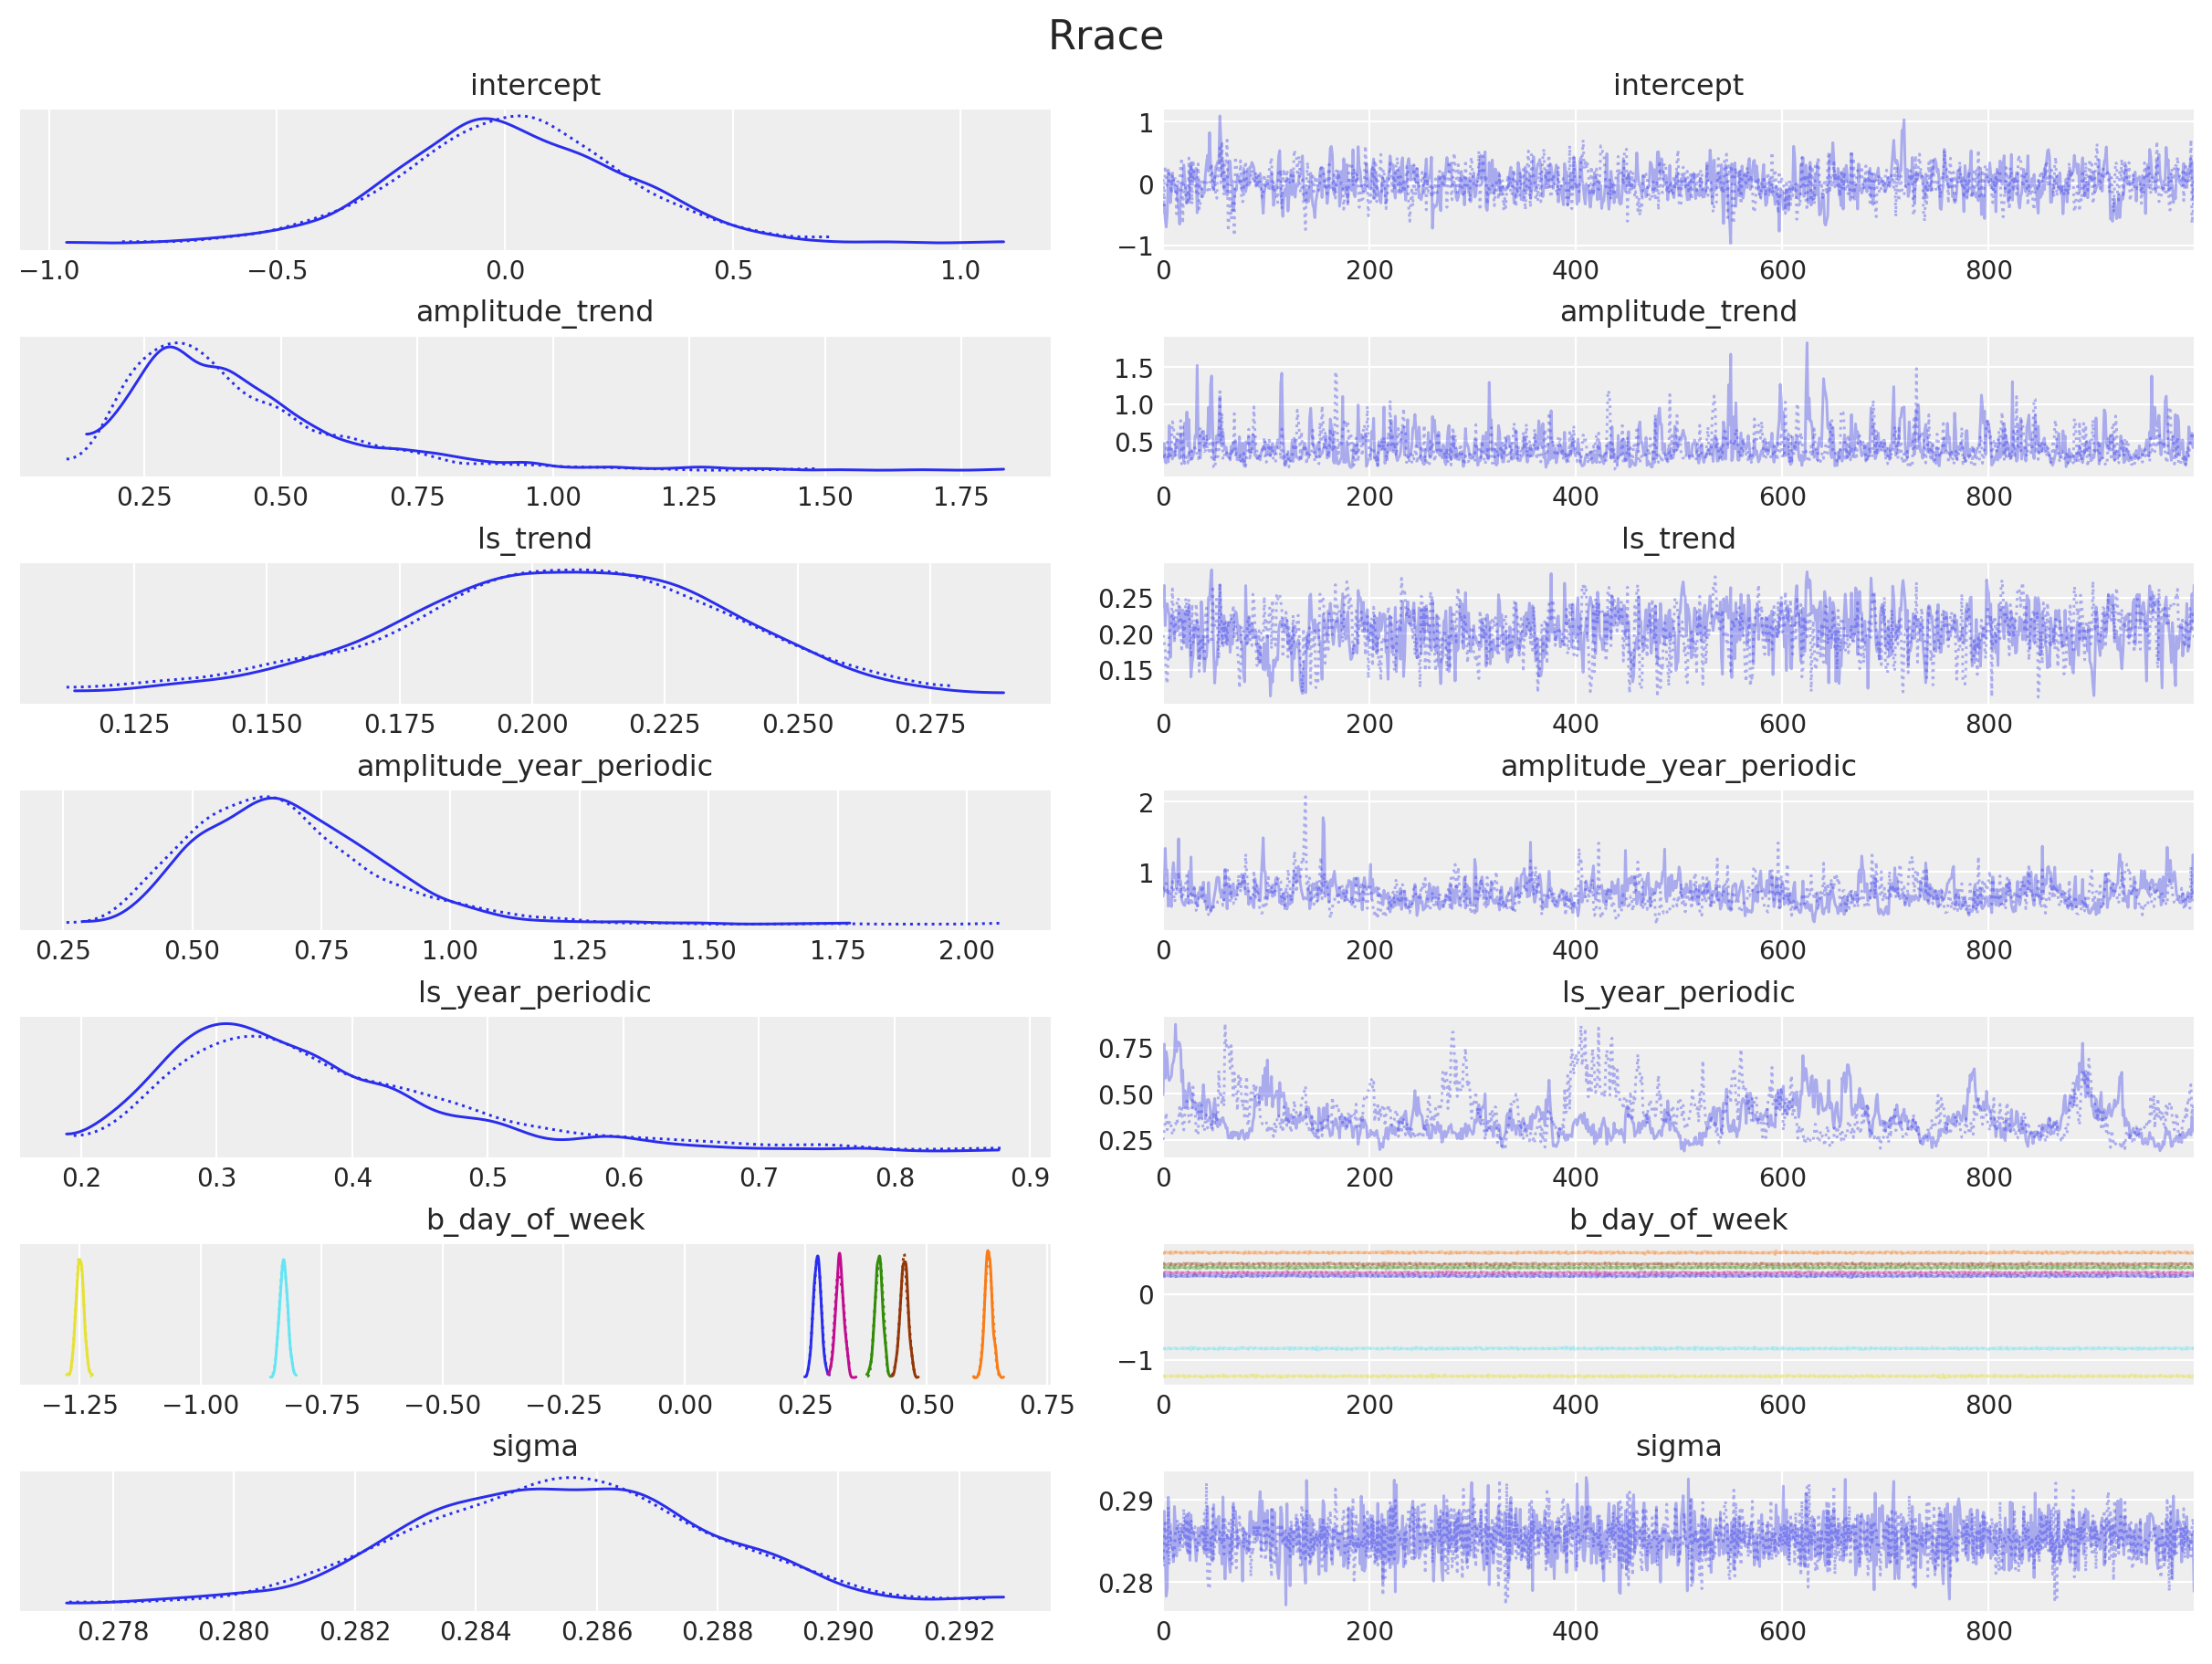

In [21]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Rrace", fontsize=16)

In [22]:
pp_mu_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    idata["posterior"]["mu"].expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["obs", "_"]],
    output_core_dims=[["obs", "_"]],
    vectorize=True,
).squeeze(dim="_")


pp_likelihood_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    posterior_predictive["posterior_predictive"]["likelihood"].expand_dims(
        dim={"_": 1}, axis=-1
    ),
    input_core_dims=[["obs", "_"]],
    output_core_dims=[["obs", "_"]],
    vectorize=True,
).squeeze(dim="_")

Text(0.5, 1.0, 'Relative Births in the USA in 1969\nPosterior Predictive')

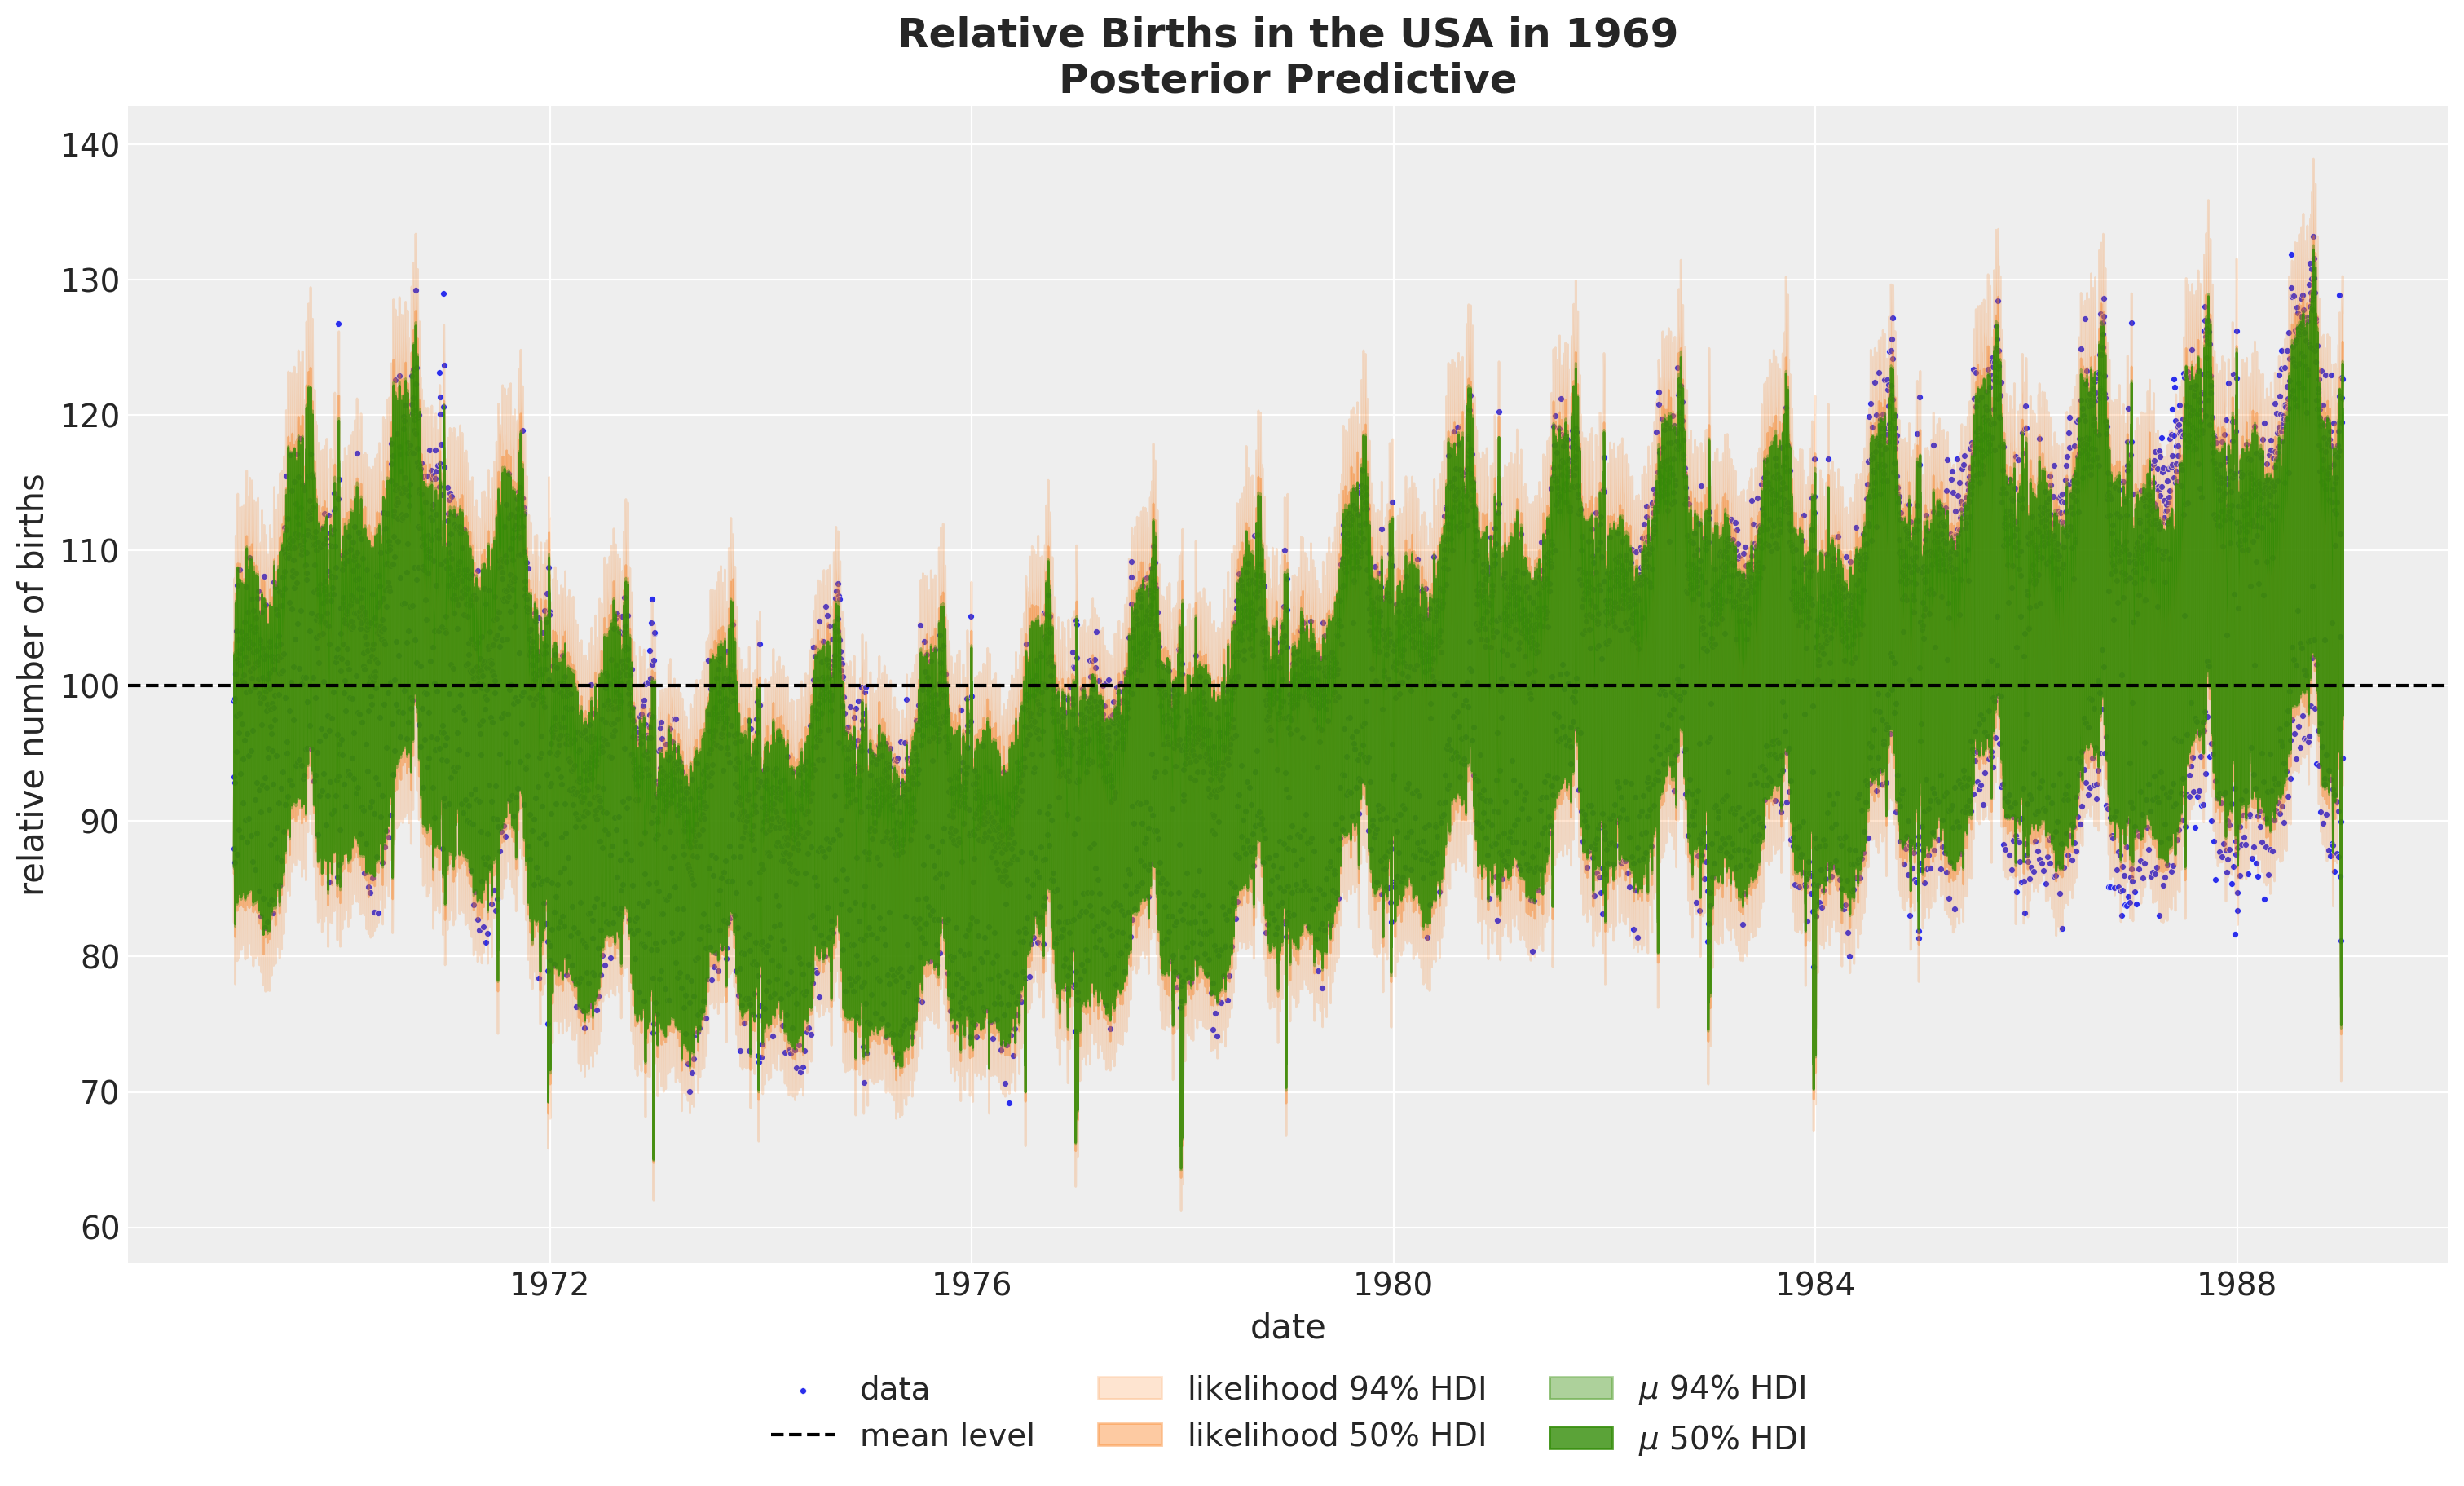

In [23]:
fig, ax = plt.subplots(figsize=(15, 9))
sns.scatterplot(
    data=data_df, x="date", y="births_relative100", c="C0", s=8, label="data", ax=ax
)
ax.axhline(100, color="black", linestyle="--", label="mean level")
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.94,
    color="C1",
    fill_kwargs={"alpha": 0.2, "label": r"likelihood $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_likelihood_original_scale,
    hdi_prob=0.5,
    color="C1",
    fill_kwargs={"alpha": 0.4, "label": r"likelihood $50\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_mu_original_scale,
    hdi_prob=0.94,
    color="C2",
    fill_kwargs={"alpha": 0.4, "label": r"$\mu$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_mu_original_scale,
    hdi_prob=0.9,
    color="C2",
    fill_kwargs={"alpha": 0.8, "label": r"$\mu$ $50\%$ HDI"},
    smooth=False,
    ax=ax,
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.07), ncol=3)
ax.set(xlabel="date", ylabel="relative number of births")
ax.set_title(
    label="Relative Births in the USA in 1969\nPosterior Predictive",
    fontsize=18,
    fontweight="bold",
)

In [33]:
pp_b_day_of_year2_original_scale = xr.apply_ufunc(
    births_relative100_pipeline.inverse_transform,
    idata["posterior"]["b_day_of_year2"].expand_dims(dim={"_": 1}, axis=-1),
    input_core_dims=[["day_of_year2", "_"]],
    output_core_dims=[["day_of_year2", "_"]],
    vectorize=True,
).squeeze(dim="_")

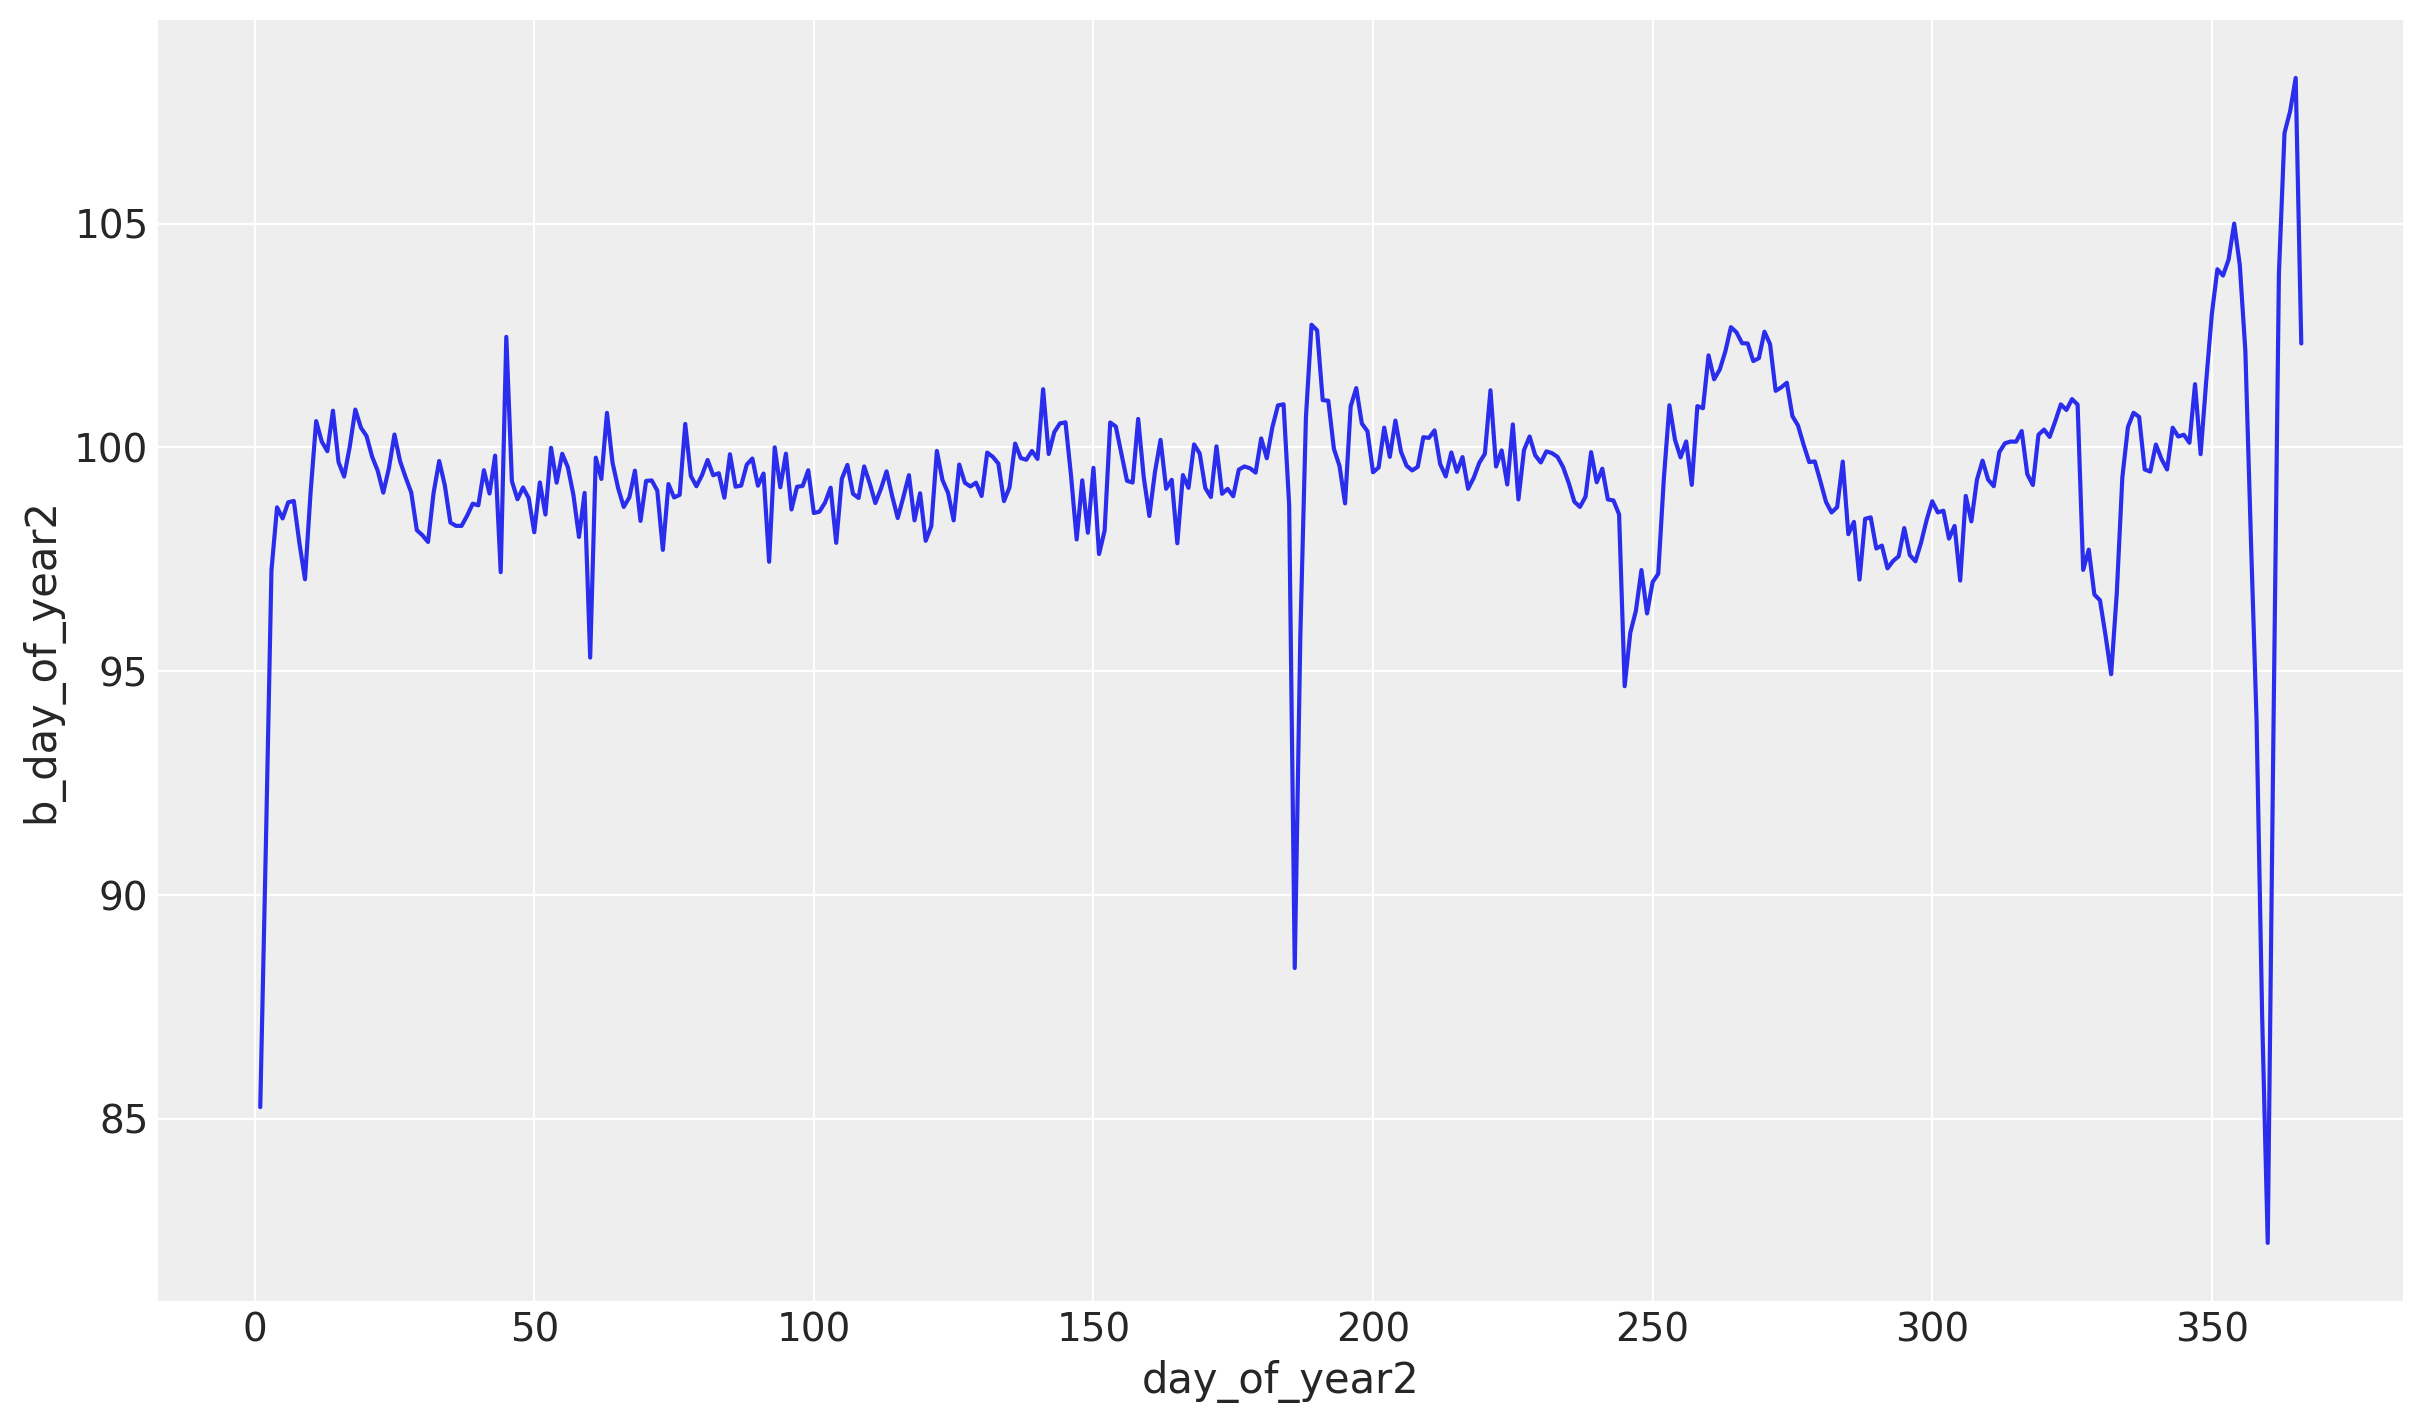

In [35]:
pp_b_day_of_year2_original_scale.mean(dim=("chain", "draw")).plot()

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Text(0.5, 1.0, 'Posterior Predictive')

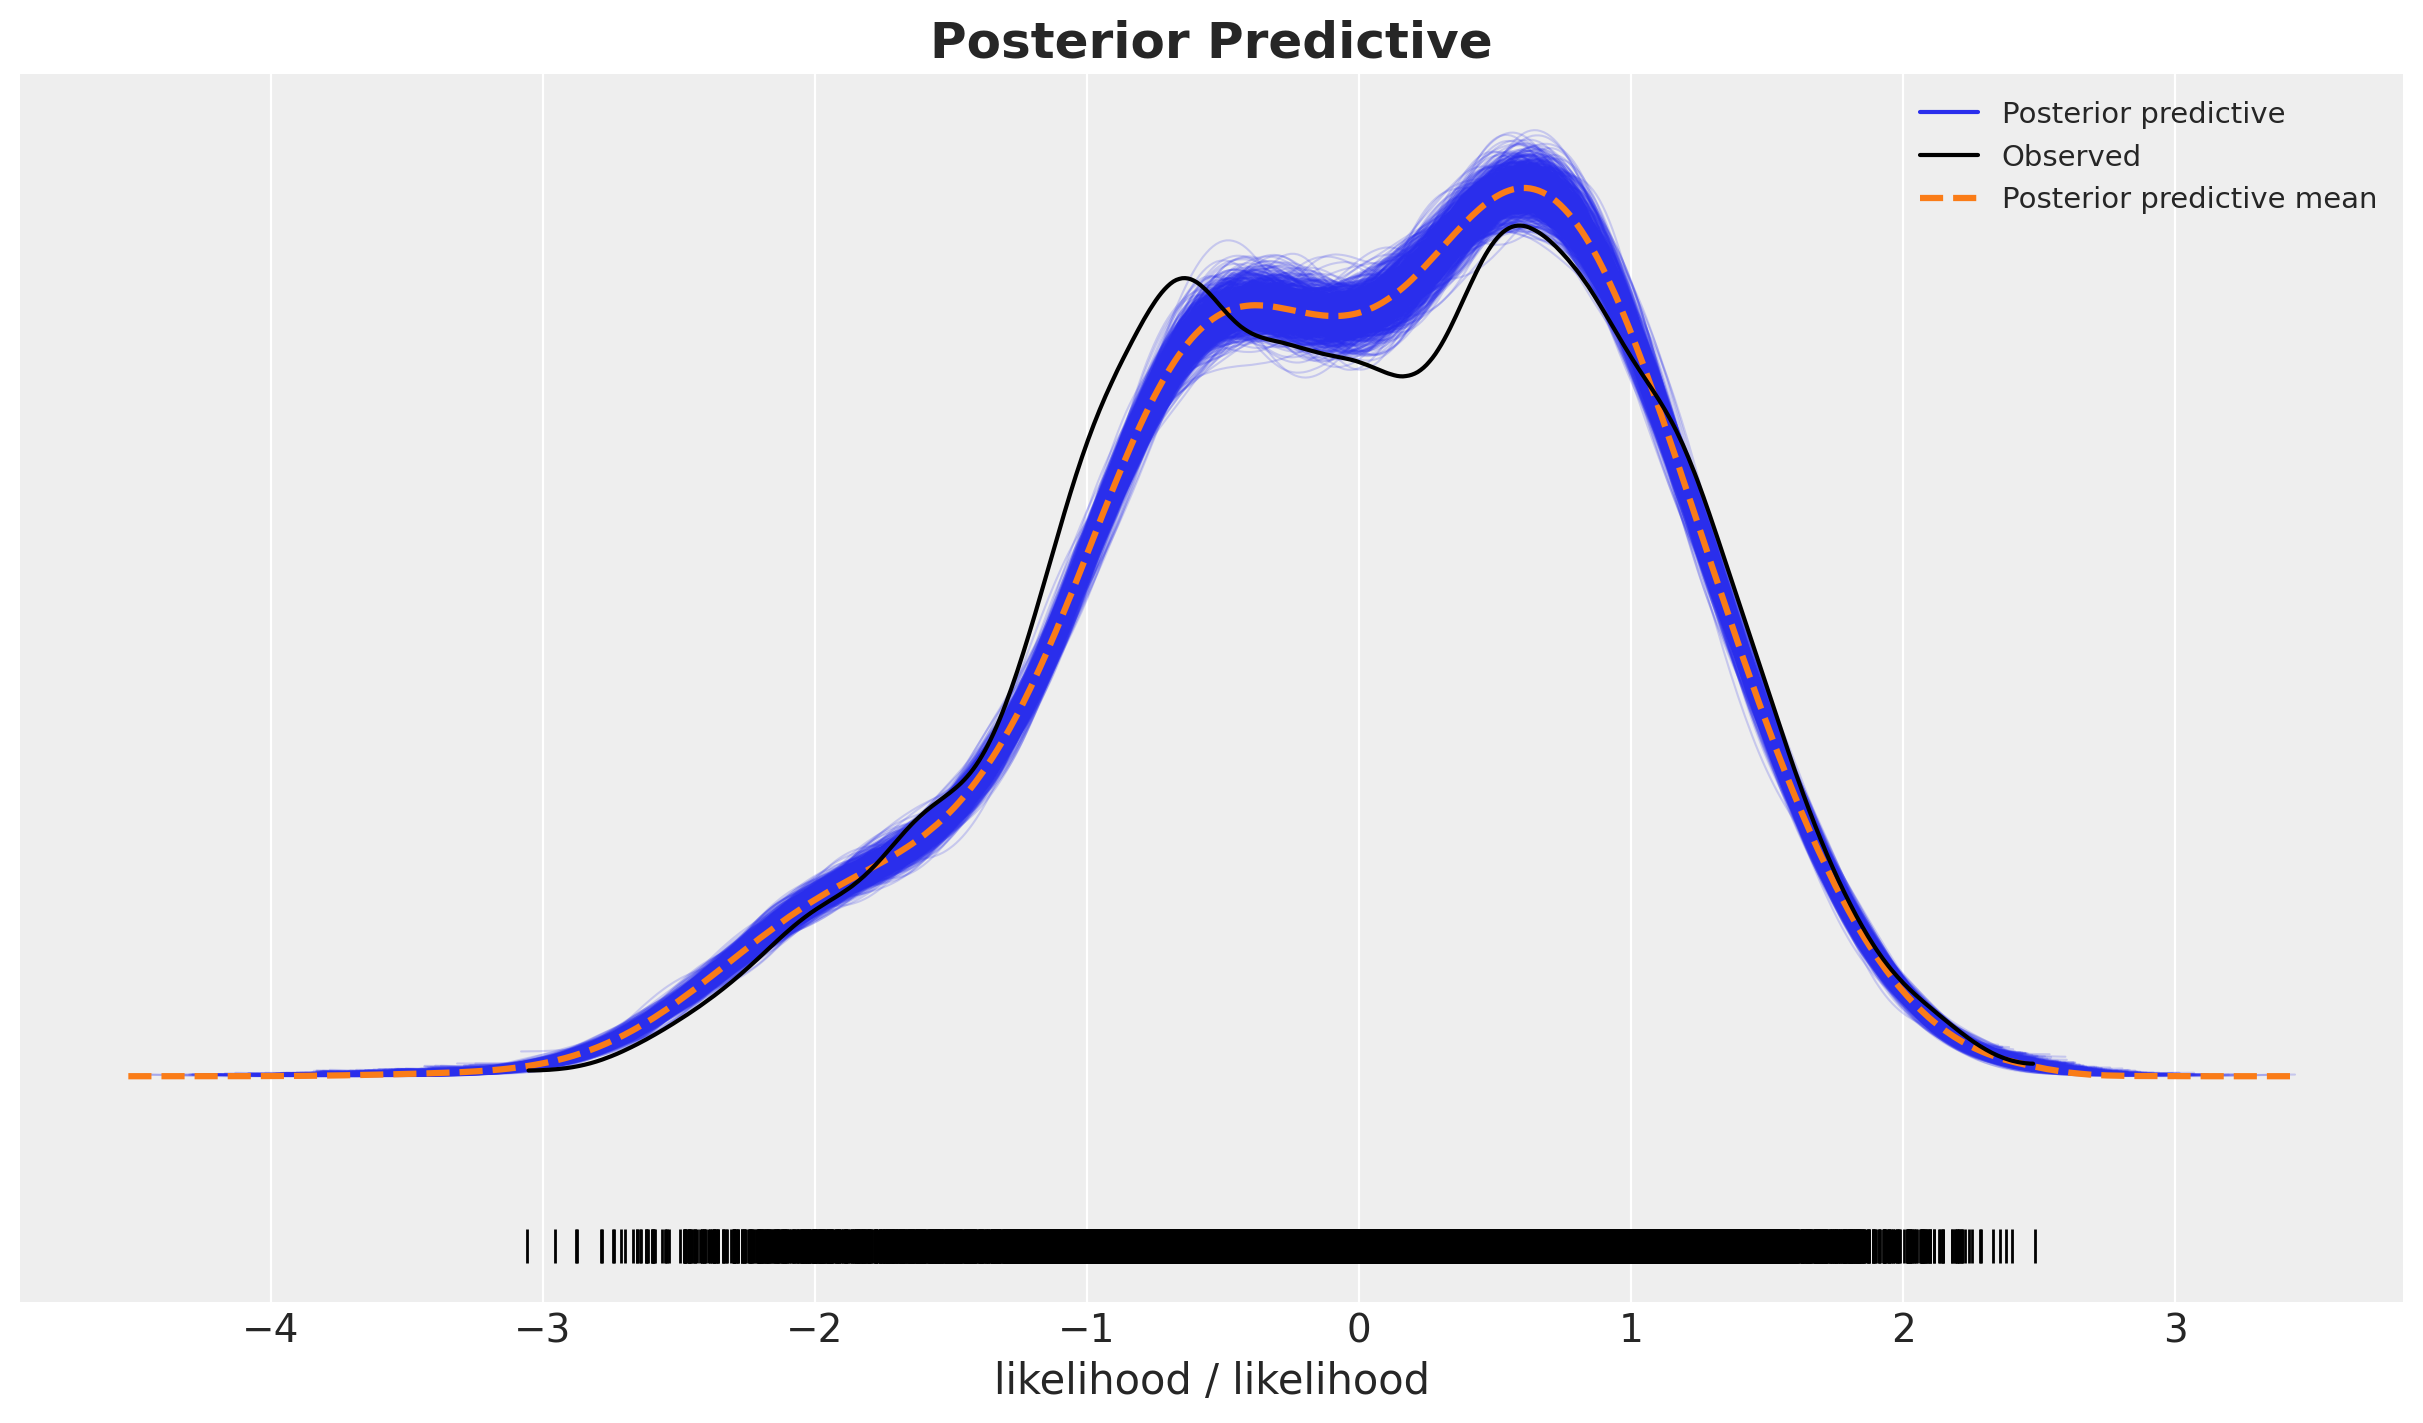

In [24]:
fig, ax = plt.subplots()
az.plot_ppc(
    data=posterior_predictive,
    num_pp_samples=1_000,
    observed_rug=True,
    random_seed=seed,
    ax=ax,
)
ax.set_title(label="Posterior Predictive", fontsize=18, fontweight="bold")